In [28]:
%display None

In [29]:
from itertools import product
from itertools import combinations
from collections import defaultdict
import time
import sage.graphs.graph_plot

In [169]:
n =4
q = 2
#FF = GF(9,'c')
FF = GF(q)
so = FF.cardinality()^n-1
thm = (FF.cardinality()^n-1)^(n-1)
mult = (q-1)^(n-1)*(add([q^i for i in range(n)])^(n-2))
G = GL(n, FF)
M = MatrixSpace(FF,n,n)
V = VectorSpace(FF,n)
fact = (q^n-1)^(n-1)
nq=gaussian_binomial(n,1,q=q)

def get_hyperplanes(): #generate all hyperplanes of gl(n,q)
    H = []
    for i in range(n):
        h = matrix(FF,n-1,n)
        for j in range(n):
            if j<i:
                h[j,j] = 1
            if j>i:
                h[j-1,j] = 1
        if i >0:
            comblist = [p for p in product(GF(q), repeat=i)]
            num = len(comblist)
            for k in range(num):
                b = h
                v = comblist[k]
                for l in range(i):
                    b[l,i] = v[l]
                H.append(copy(b))
        else: H.append(h)
    return H

def is_reflection(g):
    n = G.degree()
    M = g.matrix() - (G[0]**0).matrix()
    KM = M.kernel()
    return KM.dimension() == n-1

def is_transvection(g):
    return is_reflection(g) and M(g).determinant() == 1


def get_transvections():
    R = []
    for g in G:
        if is_transvection(g):
            R.append(g)
    return R

def get_refls():
    R = []
    for g in G:
        if is_reflection(g):
            R.append(g)
    return R

def get_singer(): #find all singer cycles in a list
    S = []
    for g in G:
        if g.multiplicative_order() == so:
            S.append(g)
    return S

def get_reg_ells():
    S = []
    #D = defaultdict(int)
    #D2 = defaultdict(tuple)
    for g in G:
        A = M(g)
        cp = A.charpoly()
        if cp.is_irreducible():
            #D[cp] += 1
            #D2[cp] += (g,)
            S.append(g)
    return S

def sing_with_det(alp):
    c1=[]
    for c in L:
        if c.matrix().determinant() == alp:
            c1.append(c)
    return c1

def insert_row(M,k,row):
    return matrix(FF,M.rows()[:k]+[row]+M.rows()[k:])

def get_reg_ells():
    S = []
    D = defaultdict(int)
    D2 = defaultdict(tuple)
    for g in G:
        A = M(g)
        cp = A.charpoly()
        if cp.is_irreducible():
            D[cp] += 1
            D2[cp] += (g,)
            S.append(g)
    return S, D, D2
def get_fact(R,c):
    F = []
    for i in product(range(len(R)),repeat = G.degree()):
        if mul([R[i[k]] for k in range(G.degree())]) == c:
            F.append([R[i[k]] for k in range(G.degree())])
    return F

def get_fact_faster(R,c):
    F = []
    for i in product(range(len(R)),repeat = G.degree()-1):
        m = c*mul([R[i[k]] for k in range(G.degree()-1)]).inverse()
        if is_reflection(m):
            F.append([R[i[k]] for k in range(G.degree()-1)] + [m,])
    return F

#generate 1-dim vectors
def get_v1():
    H=get_hyperplanes()
    vec=[]
    for h in H:
        m=transpose(matrix(FF,h))
        v=kernel(m)
        vec.append(v)
    return vec

In [170]:
#Set up
R = get_refls()
H=get_hyperplanes()
S = get_singer()

In [171]:
#Brute force calculation to obtain all factorization for a FIXED singer cycle c
#kind of slow, even for q=1
c=S[0]
#get_fact(R,S[0])

Another way to study the case of GL(n,q) is to study the factorization of singer cycles of the same conjugacy class. For a fixed conjugacy class of a Singer cycle, we fix a sequence of valid hyperplanes (the sequence of hyperplanes that are linearly independent and also span the entire space). The easist set up is let such $H_1$, $H_2$, and $H_3$ be $H_i = \mathrm{span}(\hat{e}_i)$. Then it is very easy to generate all reflections that fixes $H_i$ because we just need to compute one row. Then the number of brute force calculation we need to go through to generate all factorizations reduces significantly.

In [146]:
#Building the sequence of standard valid H's
def valid_H_standard(n,q):
    FF = GF(q)
    V = VectorSpace(FF,n)
    valid_H = []
    for i in range(n):
        e_s= [e for e in V.basis()]
        del e_s[i]
        valid_H.append(matrix(FF, e_s))
    return valid_H


In [174]:
#Build all refelction elements
#input the sequence of desired determinants - for q=2 case, it's just 1's.
#Outputs a list of reflection sequences with chosen determinants
#Note that these are just all possible reflection combos given the desired determinant sequence 
#- still need to test if it is a factorization
def invertible_vi(n,q,dlist):
    FF = GF(q)
    #First build all possible vectors, in a form of a single matrix
    Vm =[]
    comblist = list(product(list(product(GF(q), repeat = n-1)), repeat = n))
    for comb in comblist:
        m = matrix(FF,n)
        for i in range(n):
            v = list(comb[i])
            v.insert(i,dlist[i])
            m[i] = v
        Vm.append(m)

    #Then inserting these rows into the hyperplanes to build the reflection sequences
    Hlist = valid_H_standard(n,q)
    allv = []
    for v_s in Vm:
        Rlist = []
        for i in range(n):
            v=vector(v_s[i,:])
            tab = insert_row(Hlist[i],i,v)
            ref = matrix(FF, tab)
            Rlist.append(ref)
        allv.append(Rlist)
    return allv

#Now testing each of those reflection sequences to see if it is indeed a factorization
#Insert n,q, dets, Singer

def get_fact_conj(n,q, dlist,c):
    fact = []
    allv = invertible_vi(n,q,dlist)
    for r in allv:
        test = prod(r)
        f_test= matrix(test).charpoly()
        c_conj= matrix(c).charpoly()
        if f_test == c_conj:
            fact.append(r)
    return fact


In [175]:
#Choose a Singer cycle and check its conjugacy class
c = S[0]
matrix(c).charpoly()

x^4 + x + 1

In [184]:
#Get all factorizations of the kinds with the standard valid hyperplanes of such conjugacy class
#For q=2, our determinants will always just be 1's
dlist = [1]*n
fact_fixed_conj = get_fact_conj(n,q,dlist,c)

In [178]:
#fun fact + sanity check, this should be (q-1)^(n-1)x[n]^(n-2)
len(fact_fixed_conj) == nq^(n-2)

225

In [27]:
# conju=[]
# for c in reg:
#     f=c.charpoly()
#     if f not in conju:
#         conju.append(f)
# conju

[x^3 + x^2 + 1, x^3 + x + 1]

Building the graph out of these factorizations

In [189]:
vec=get_v1()
#newvec=[vec[3],vec[1],vec[4],vec[0],vec[-2],vec[2],vec[-1]]
newvec=vec

label = []
for v in newvec:
    v1=v.basis()
    label.append(v1)
vertex={}
for v in range(nq):
    vertex[v]=str(label[v][0])

def get_edge(r):
    edge=[]
    for v in newvec:
            w = v*r
            if v!=w:
                edge.append([newvec.index(v),newvec.index(w)])
    return edge

#input a factorzation [r1,r2,r3]
def get_edges(rrr):
    edges=[]
    for i in range(n):
        edge=get_edge(rrr[i])
        edges.append(edge)
    return edges

#n_q x n_q matrix, put 1 for each edge correspondnce to build the adjacency matrix for each r_i
def adj_matrix(edge):
    M=matrix(nq)
    for e in edge:
        M[e[0],e[1]]=1
    return M

def get_adj_matrix(rrr):
    edges=get_edges(rrr)
    Mlist=[]
    for i in range(n):
        M2=matrix(nq)
        for e in edges[i]:
            M2[e[0],e[1]]=1
        Mlist.append(M2)
    return Mlist

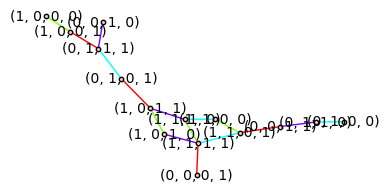

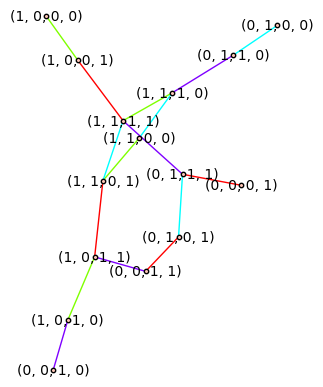

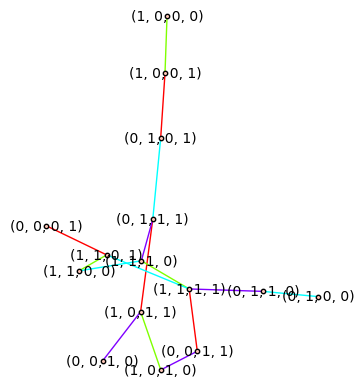

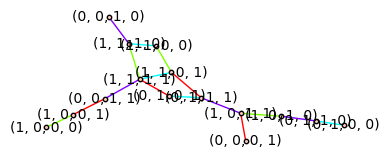

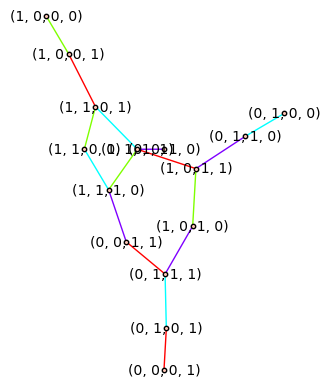

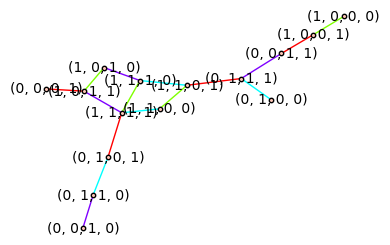

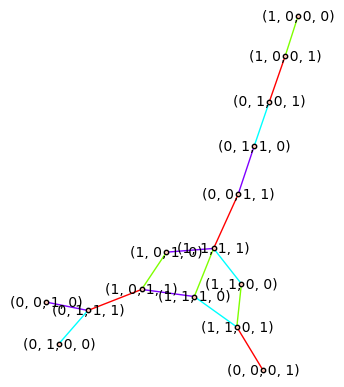

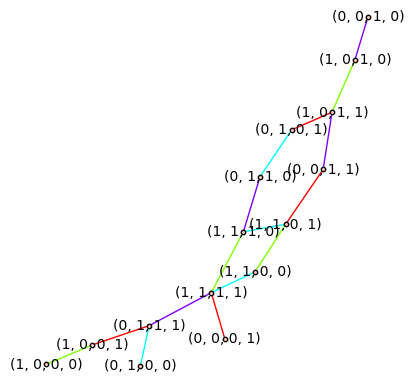

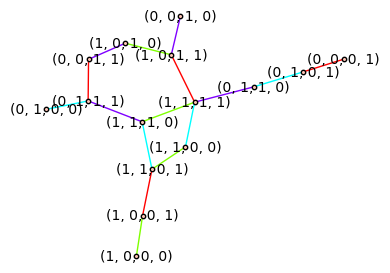

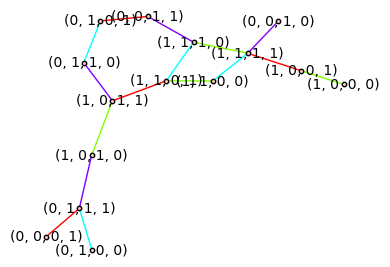

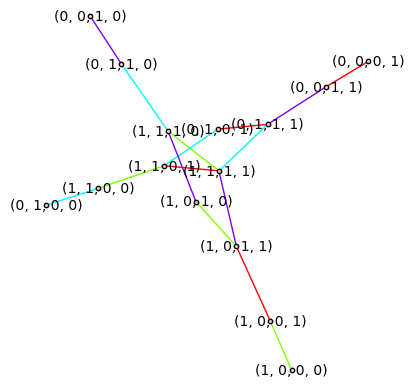

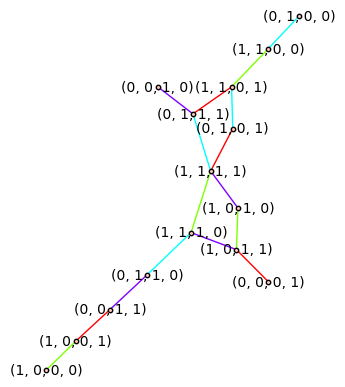

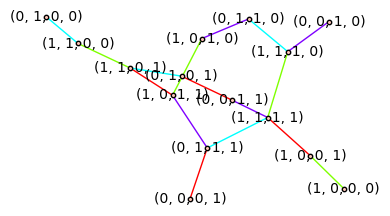

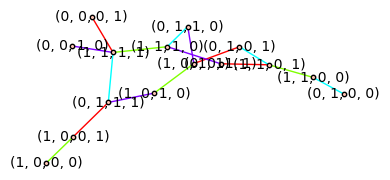

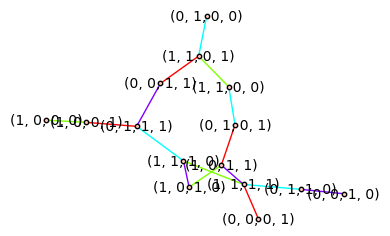

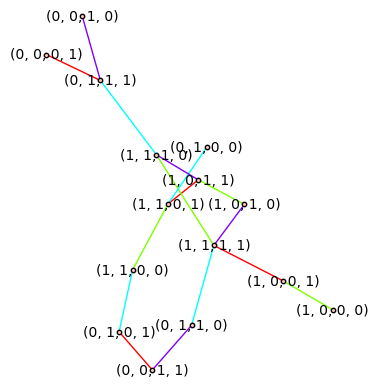

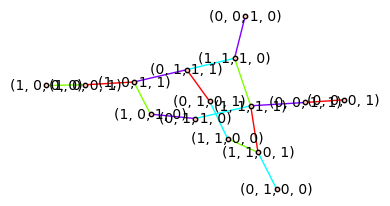

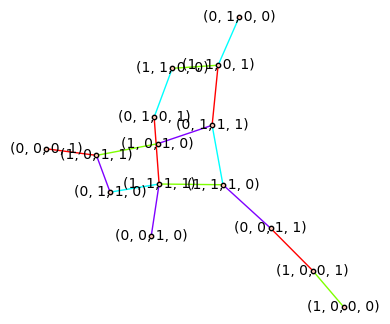

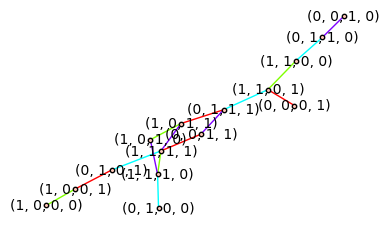

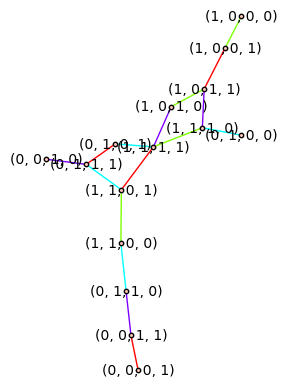

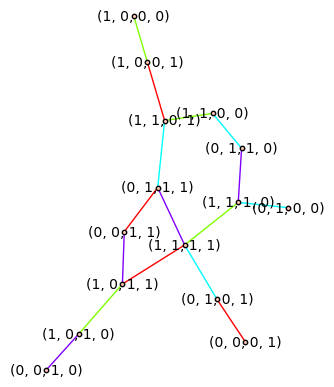

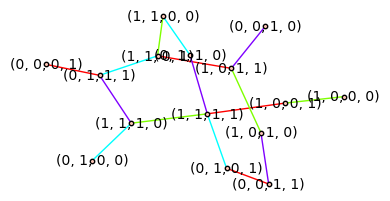

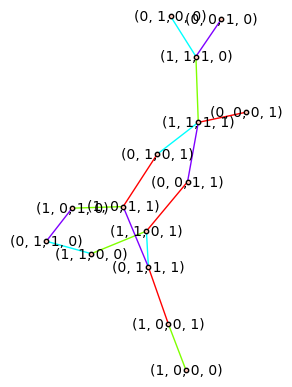

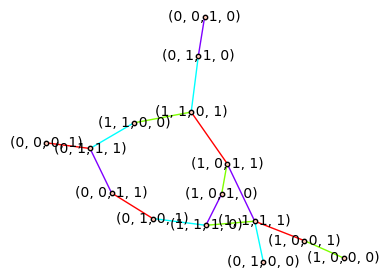

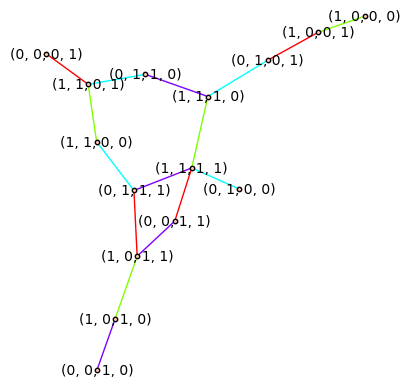

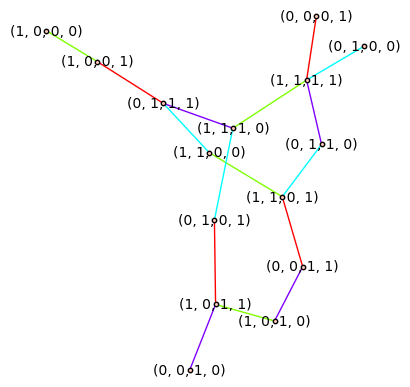

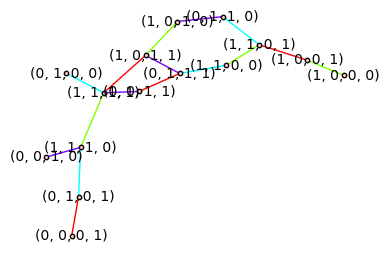

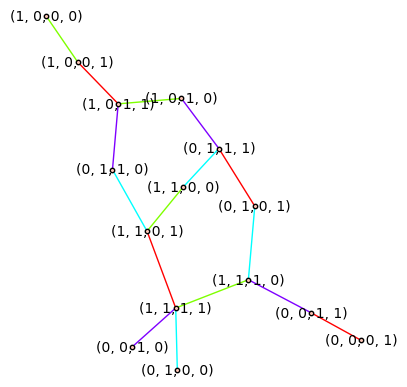

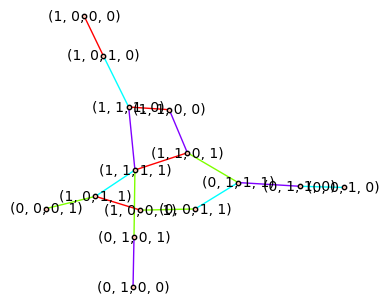

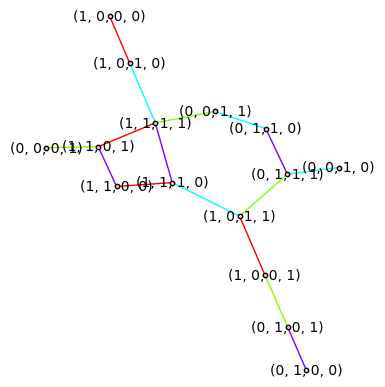

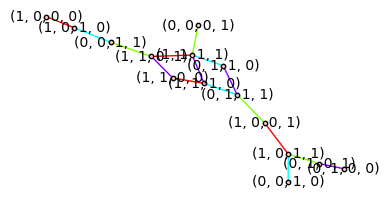

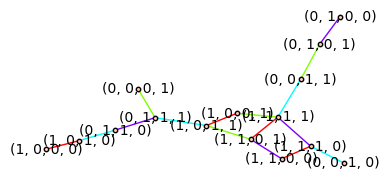

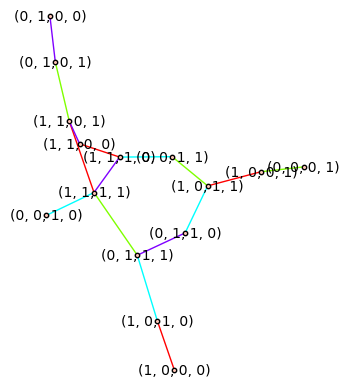

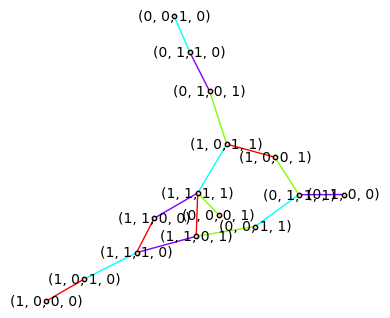

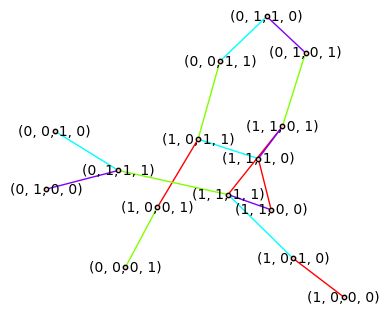

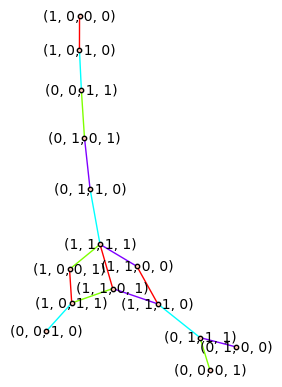

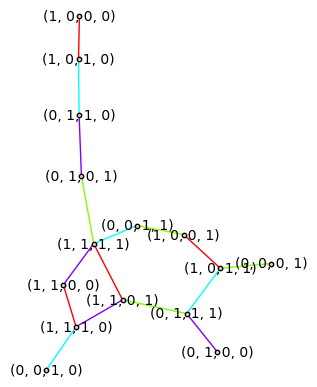

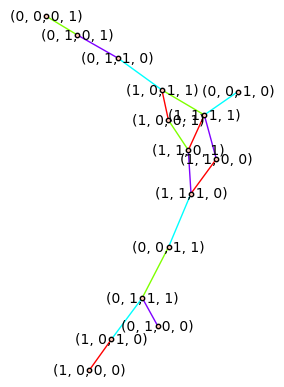

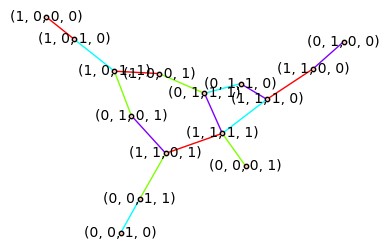

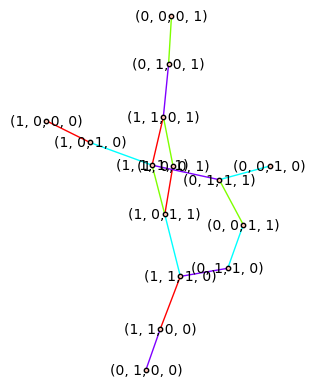

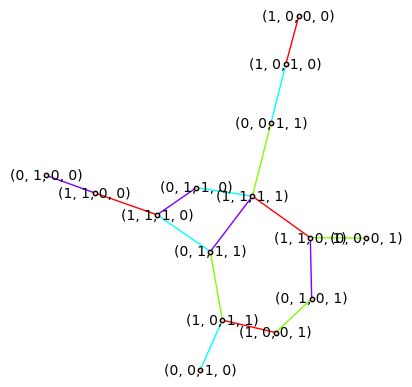

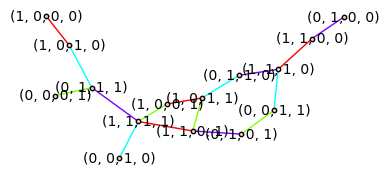

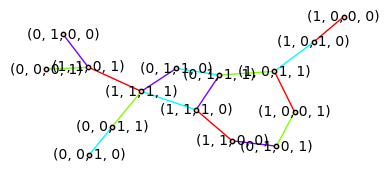

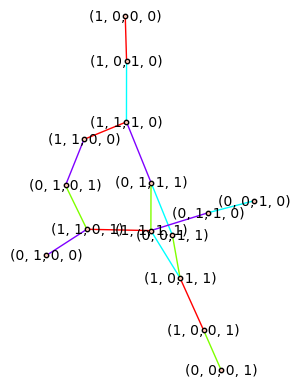

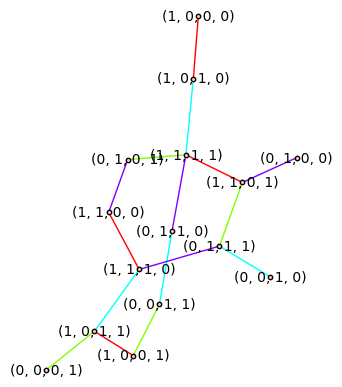

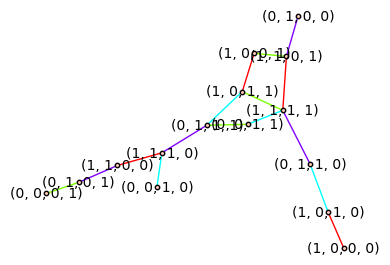

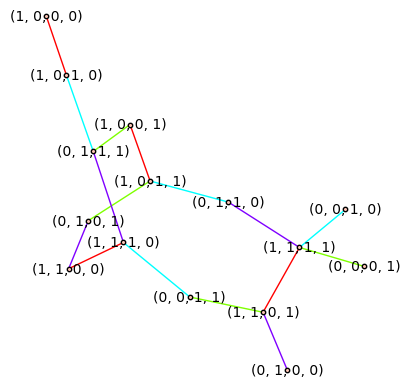

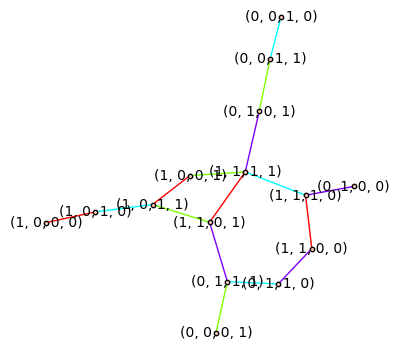

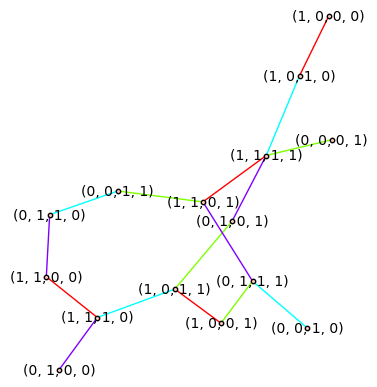

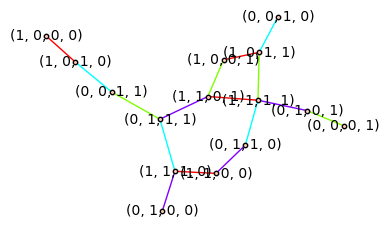

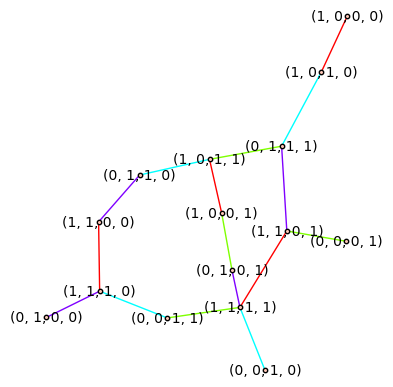

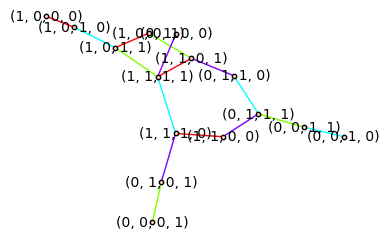

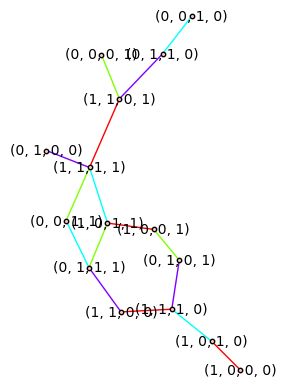

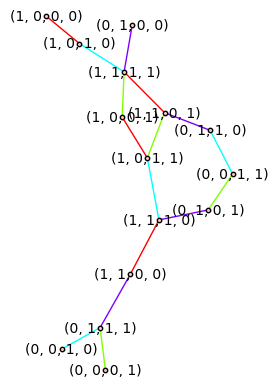

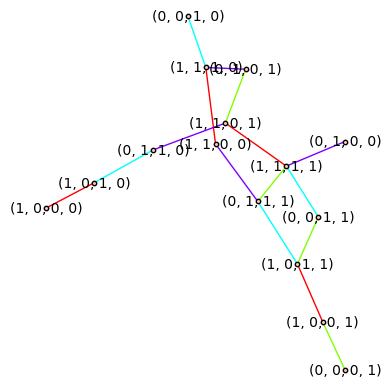

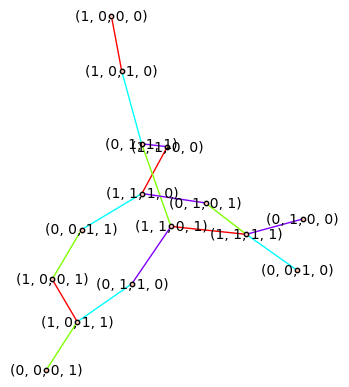

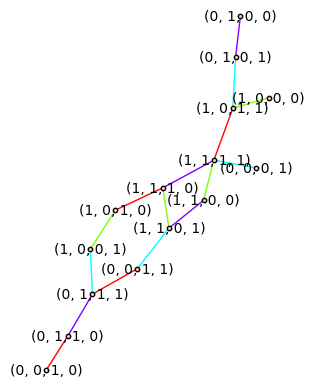

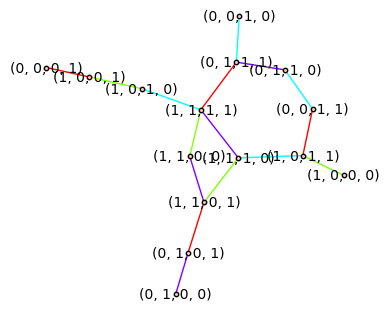

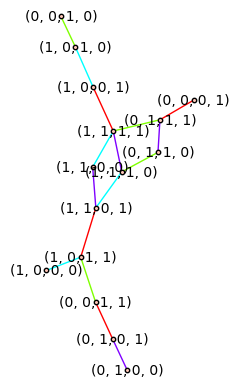

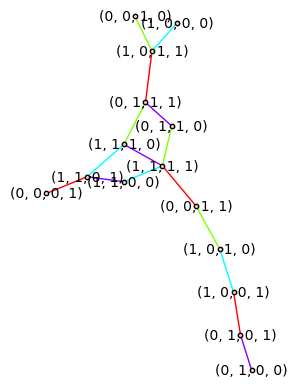

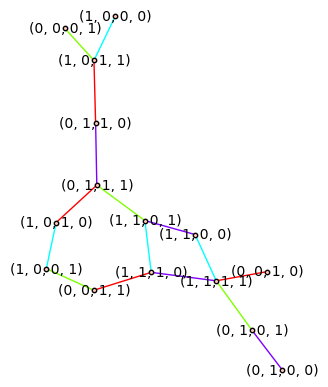

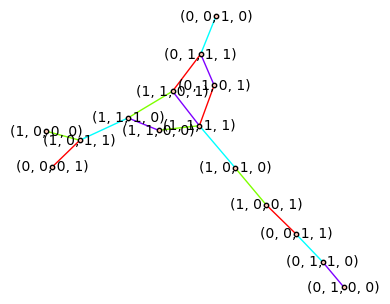

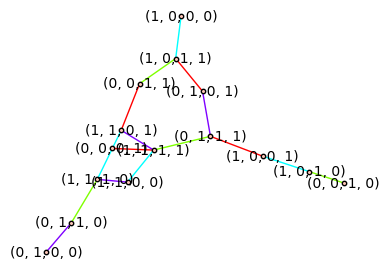

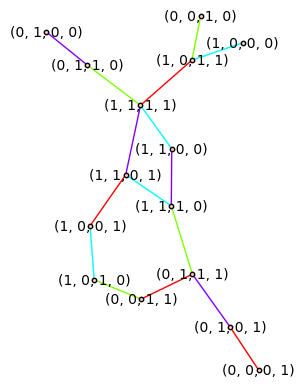

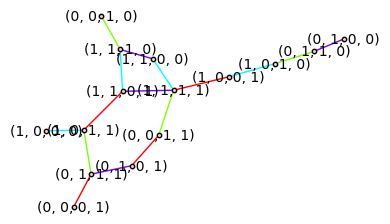

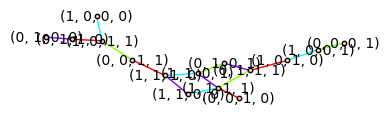

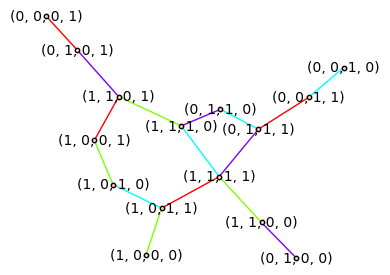

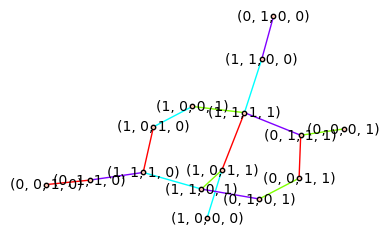

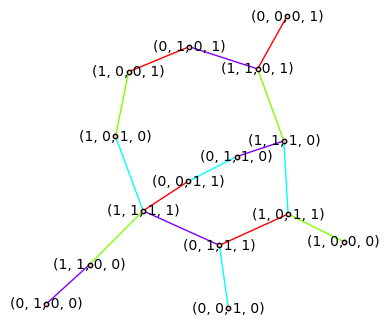

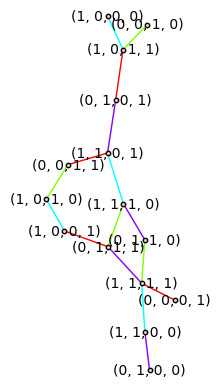

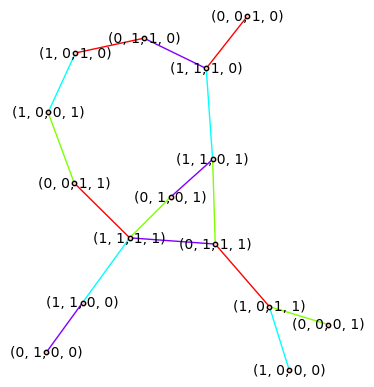

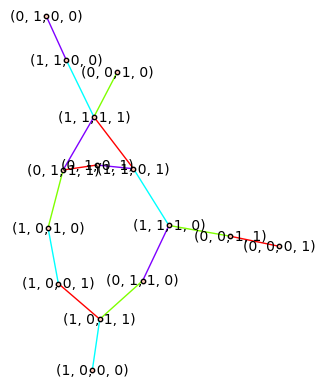

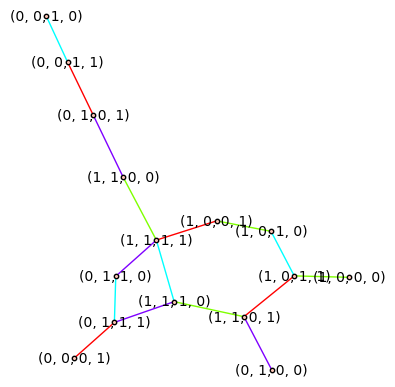

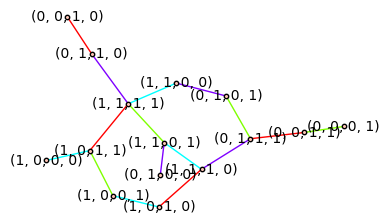

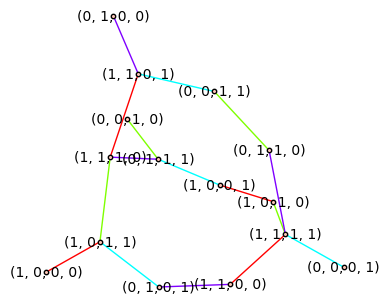

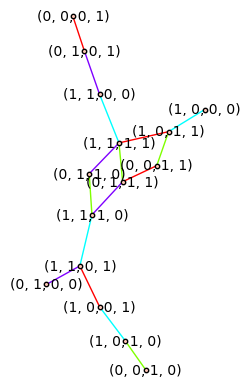

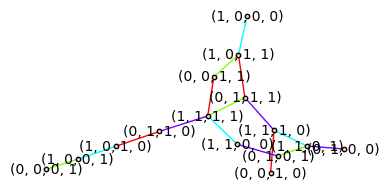

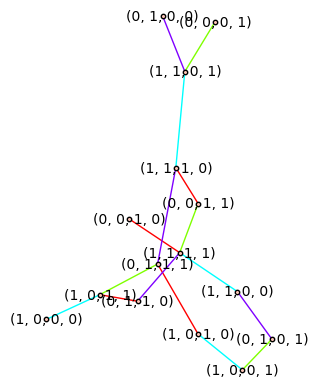

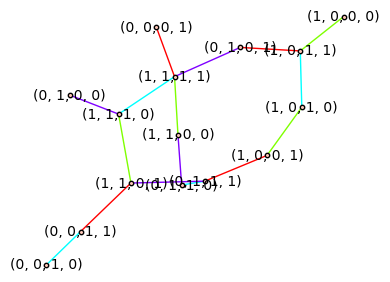

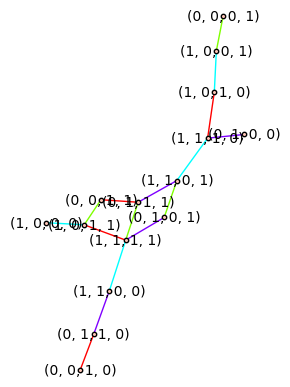

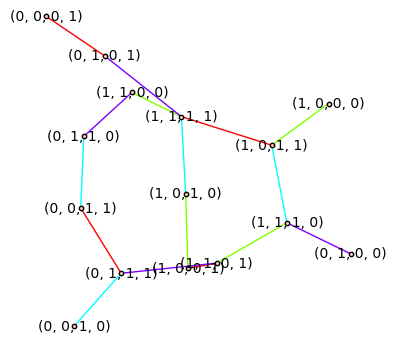

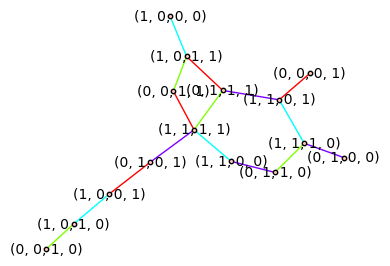

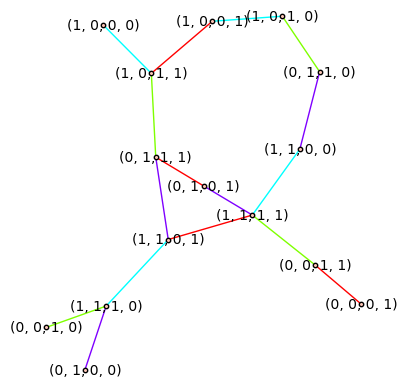

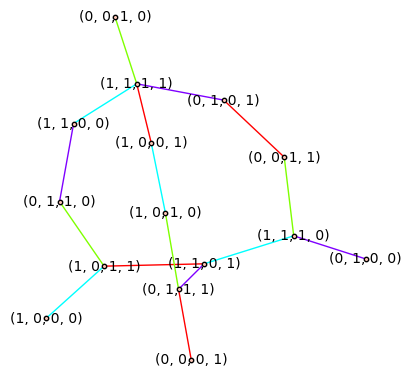

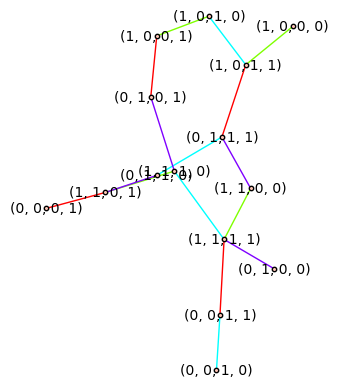

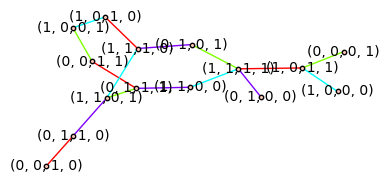

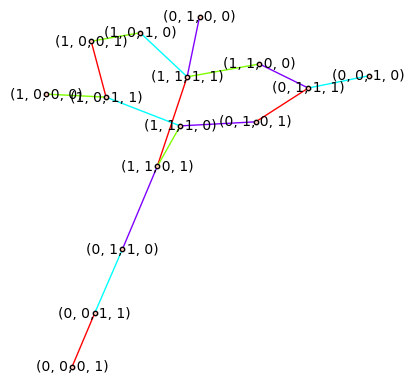

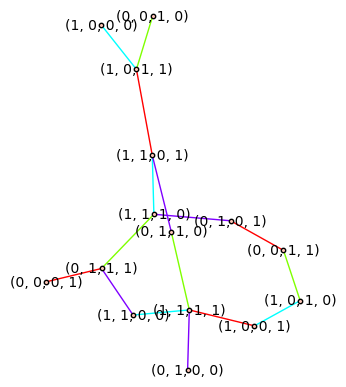

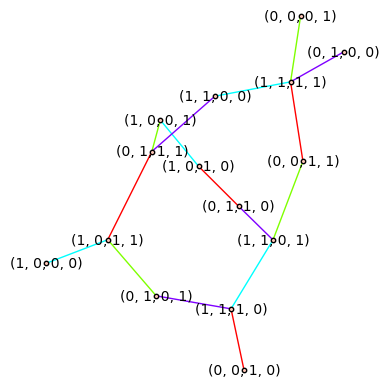

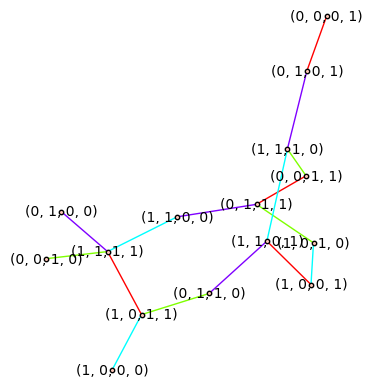

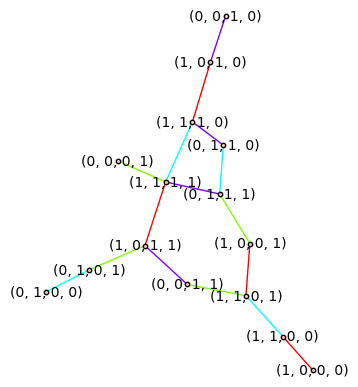

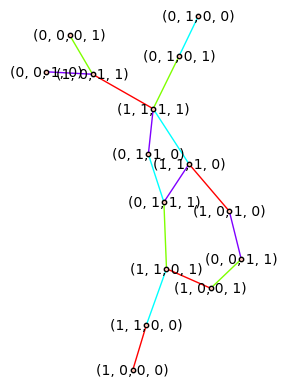

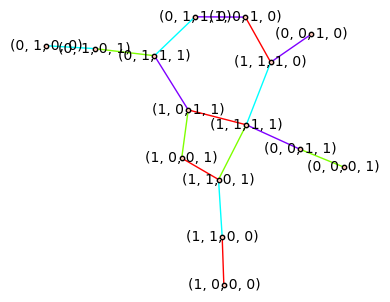

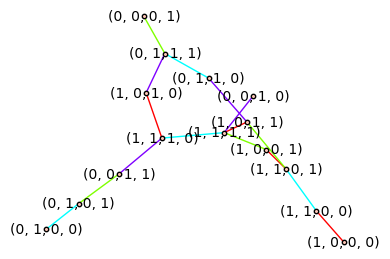

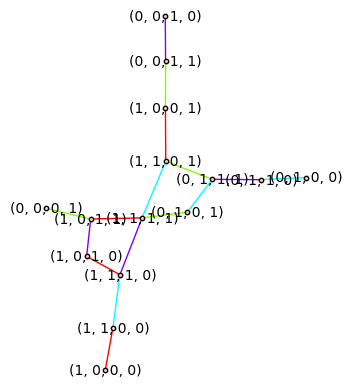

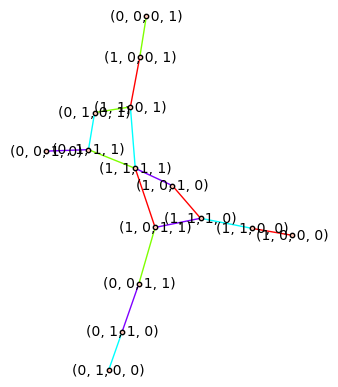

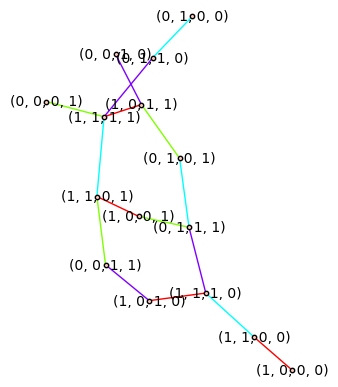

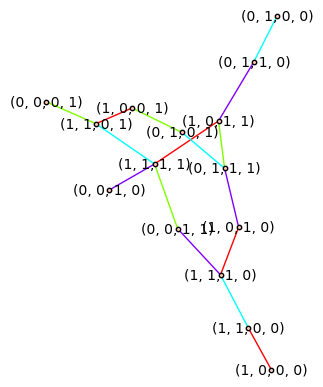

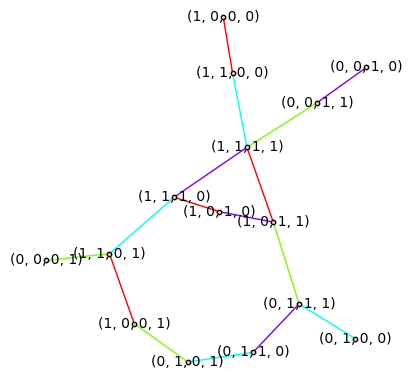

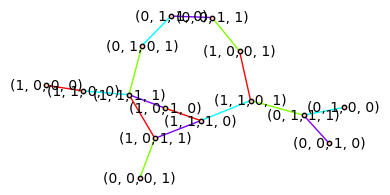

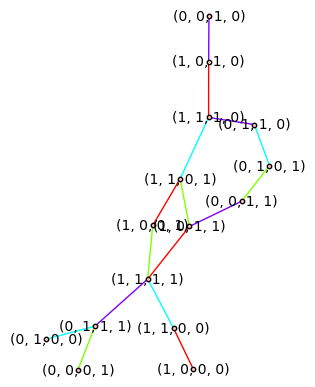

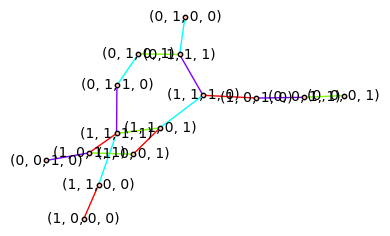

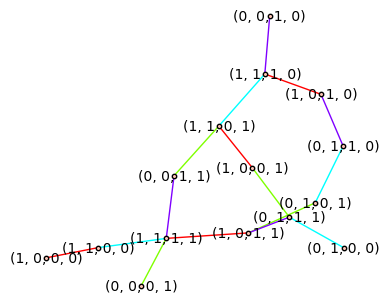

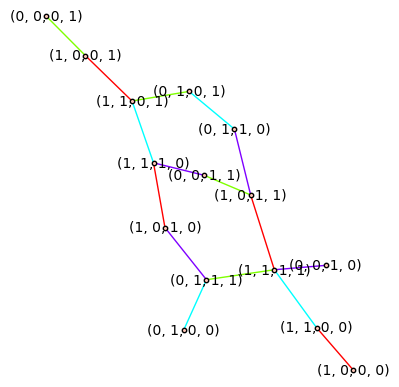

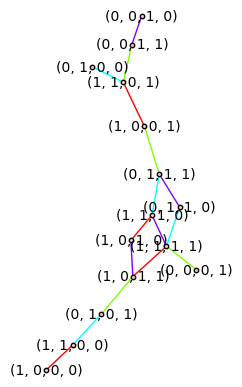

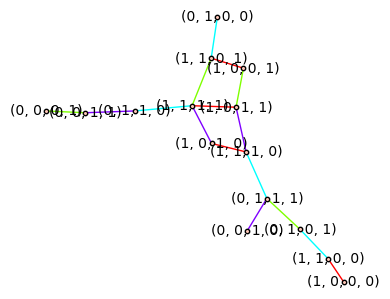

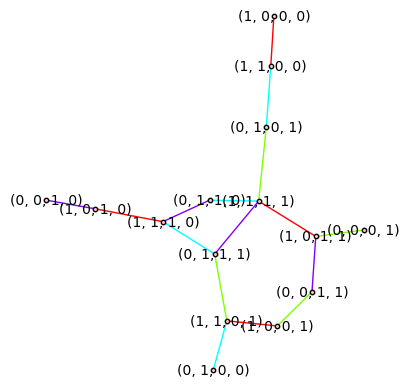

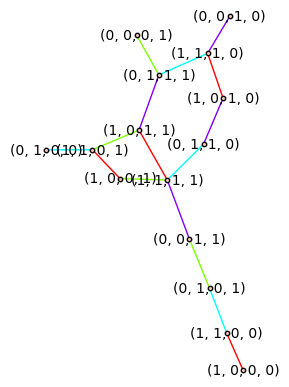

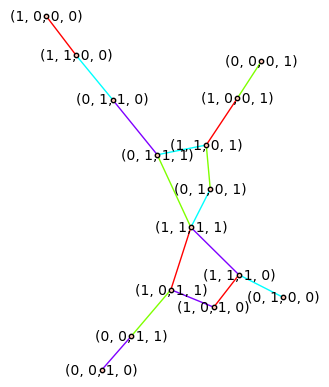

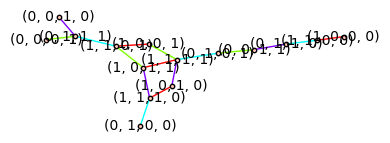

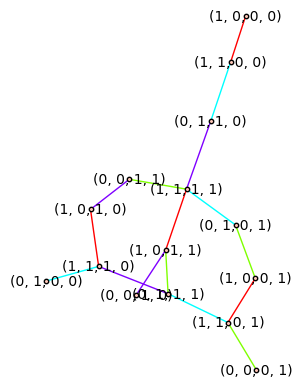

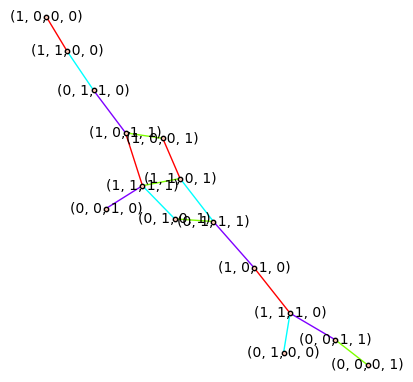

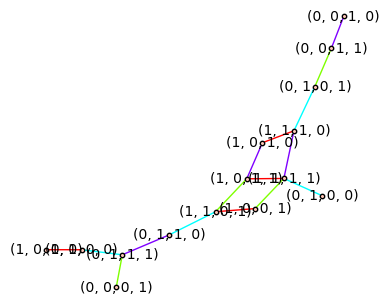

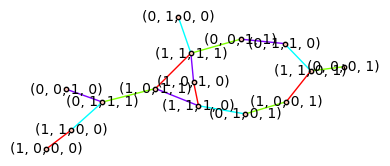

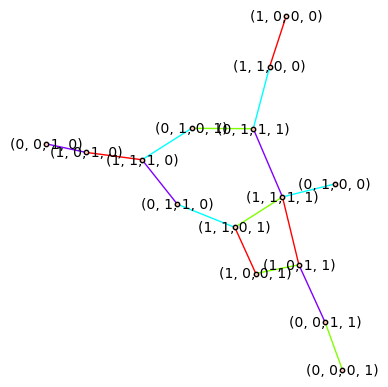

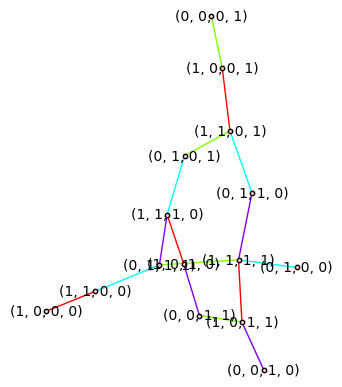

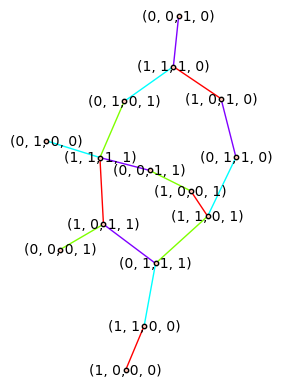

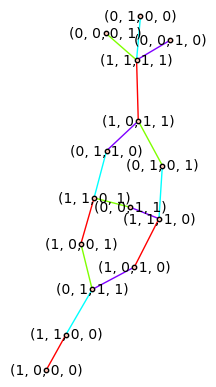

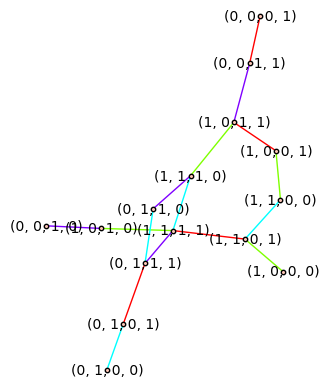

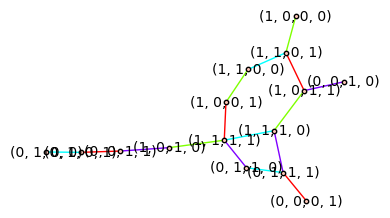

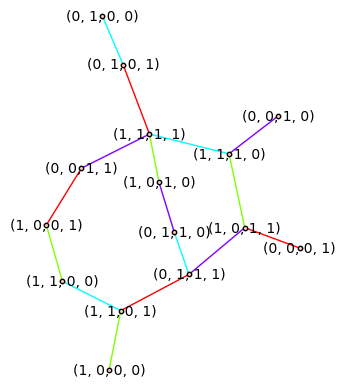

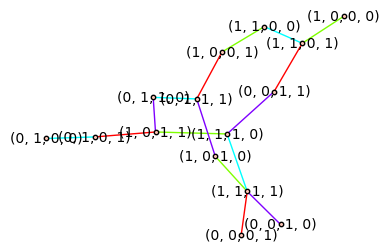

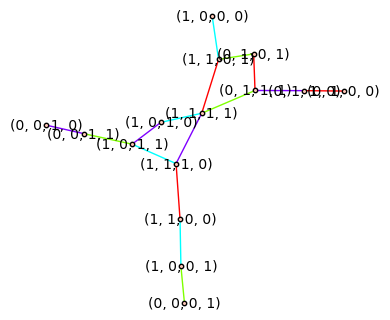

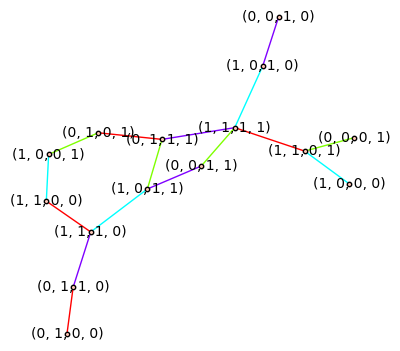

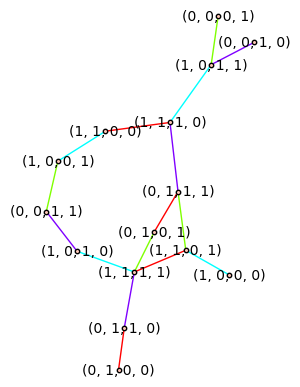

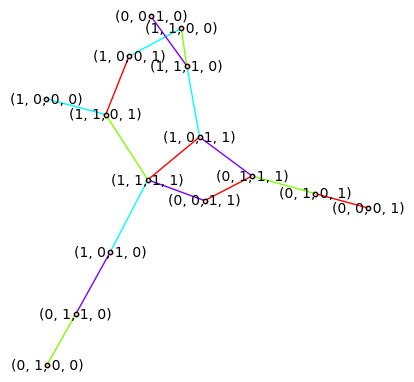

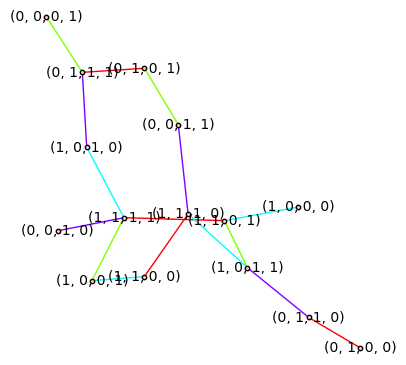

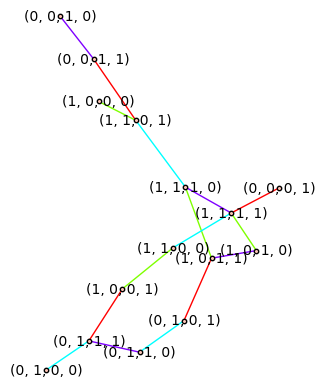

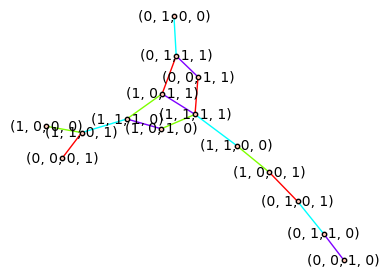

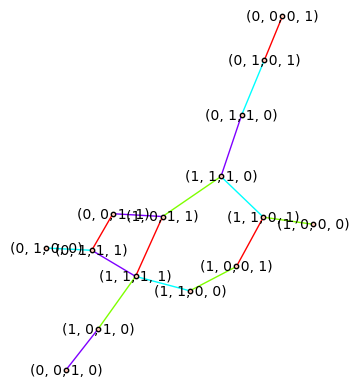

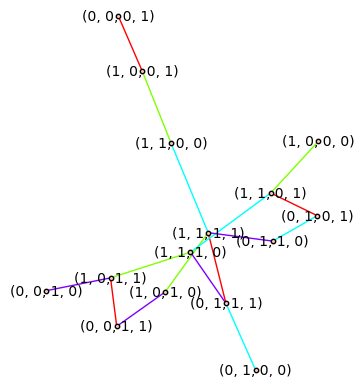

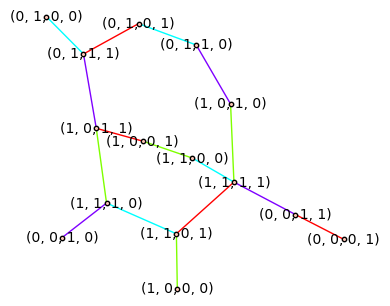

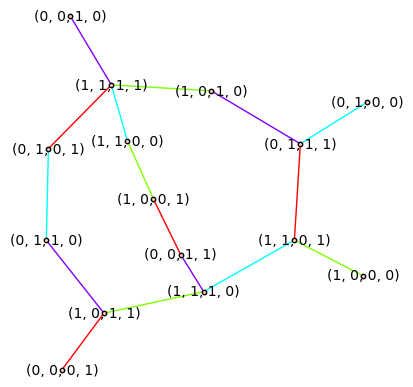

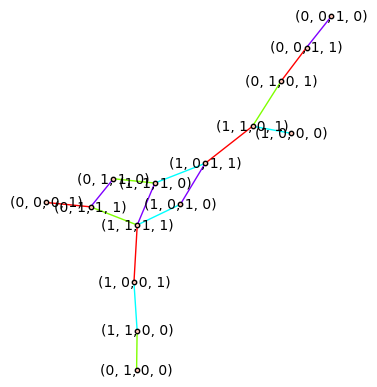

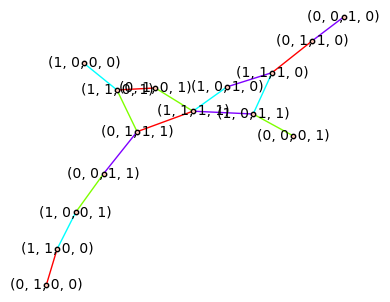

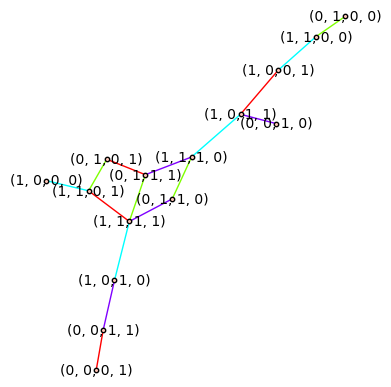

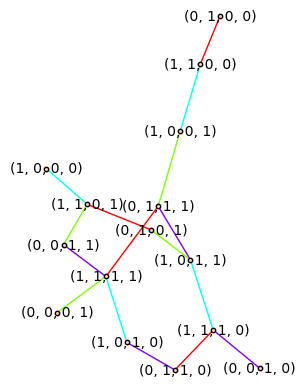

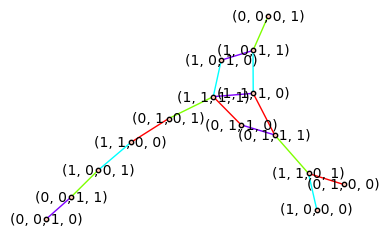

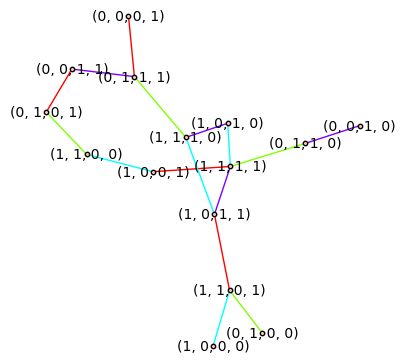

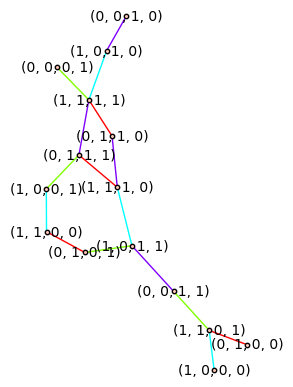

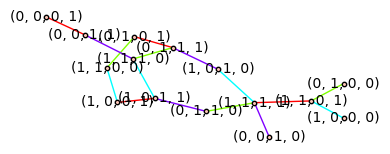

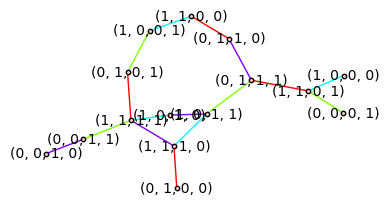

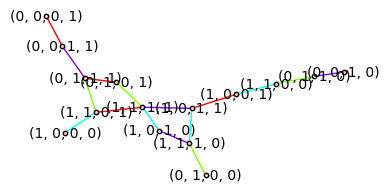

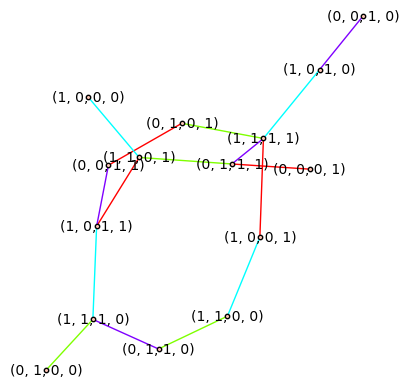

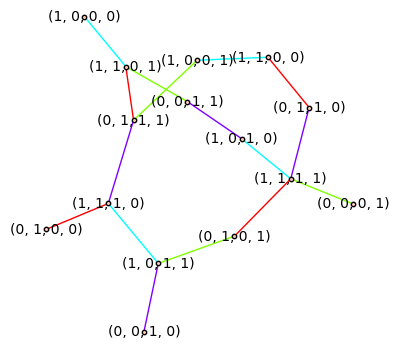

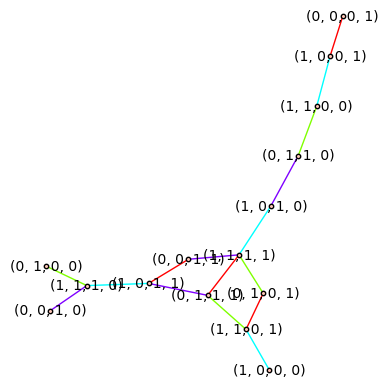

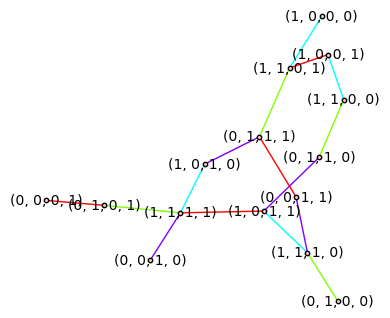

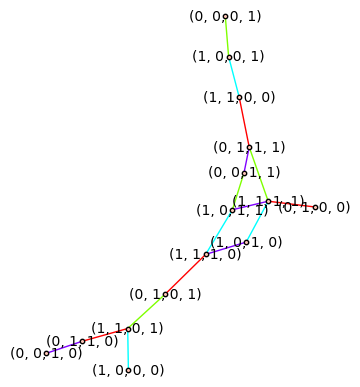

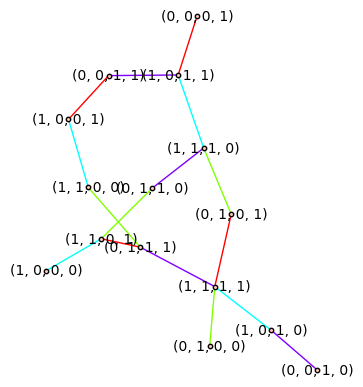

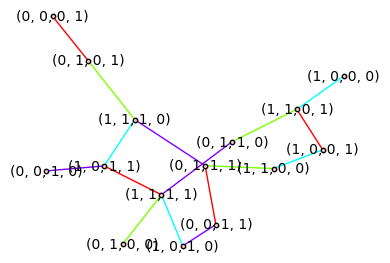

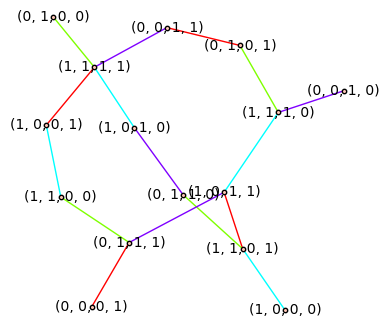

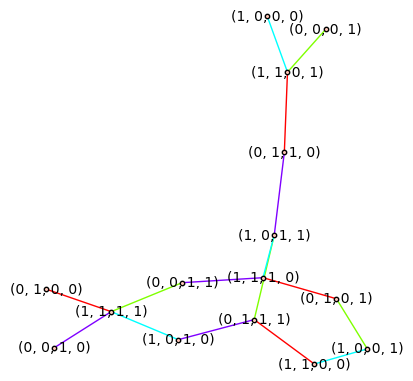

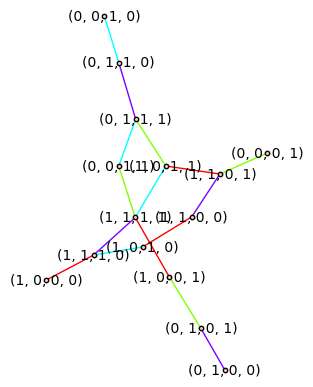

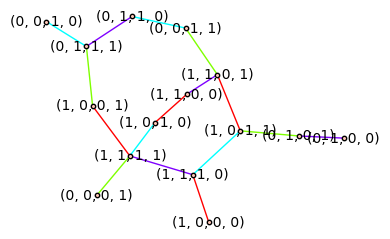

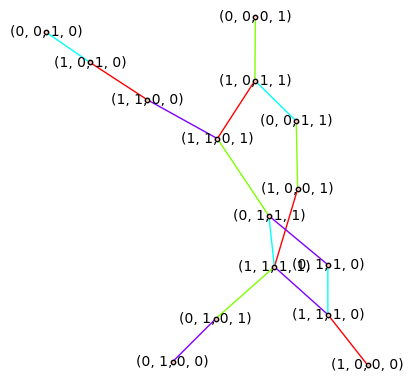

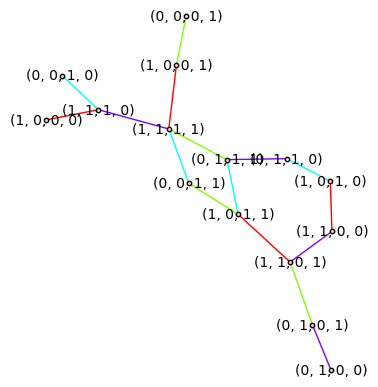

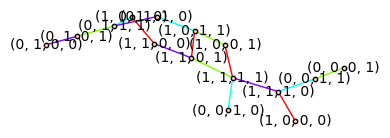

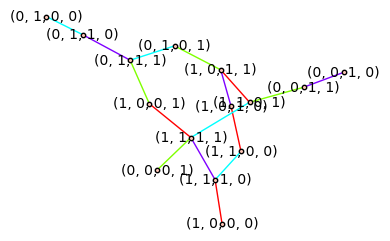

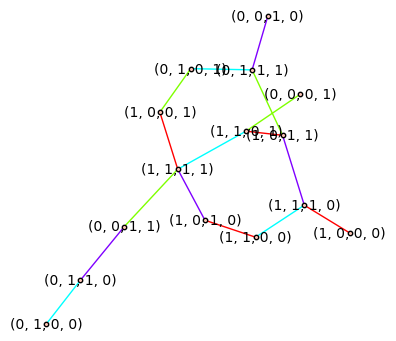

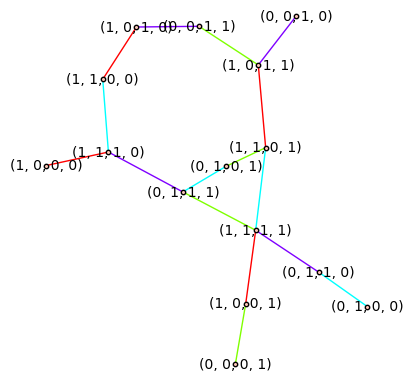

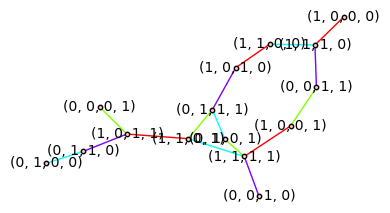

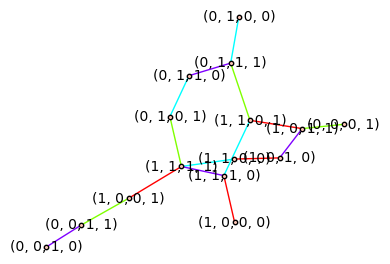

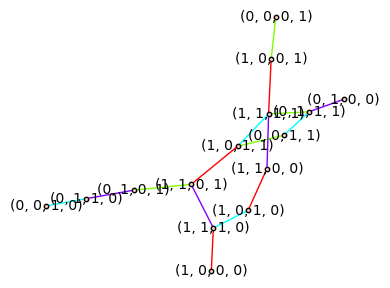

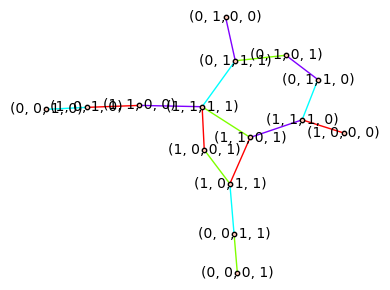

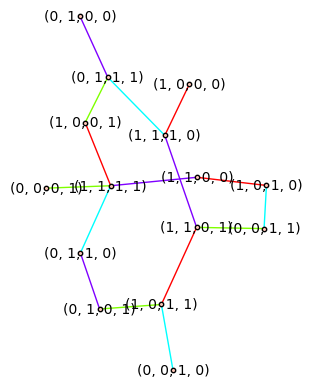

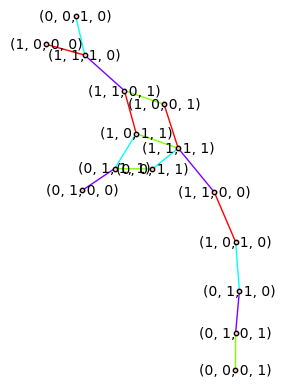

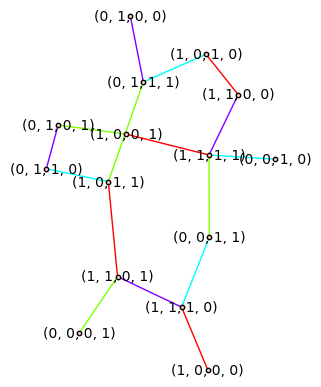

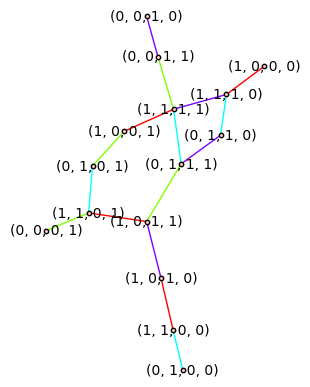

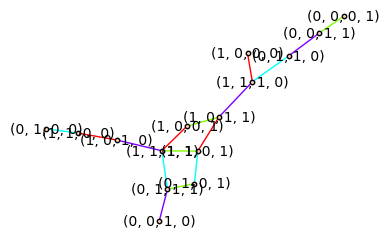

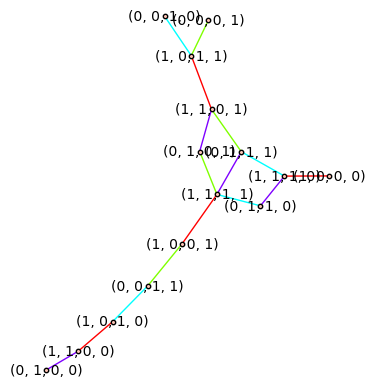

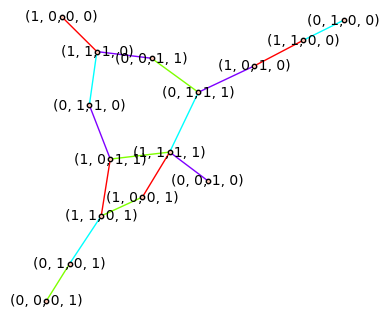

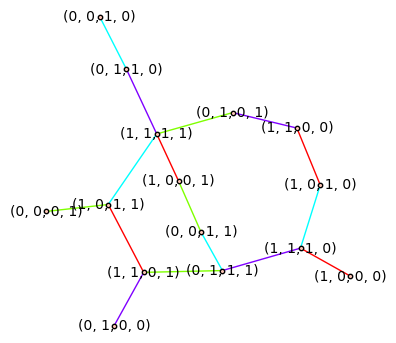

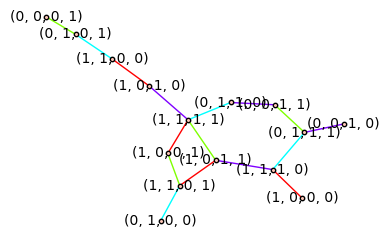

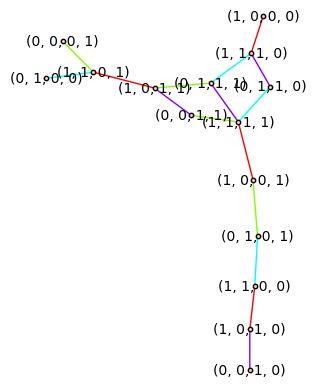

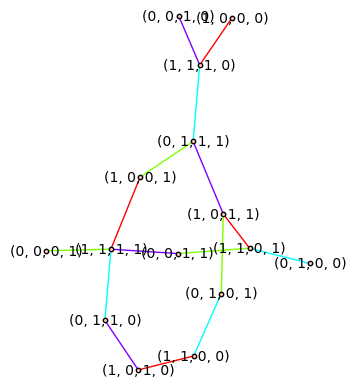

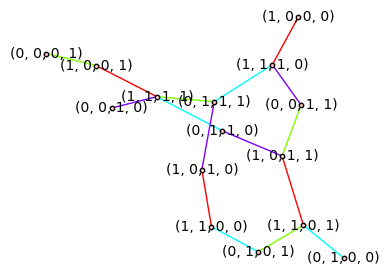

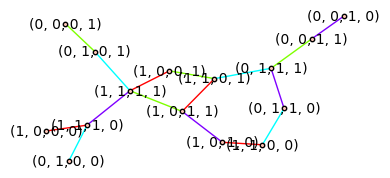

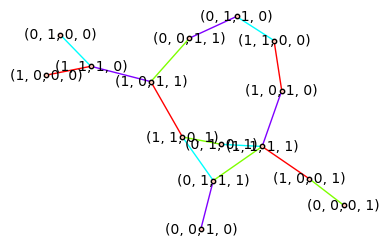

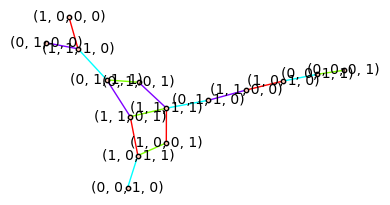

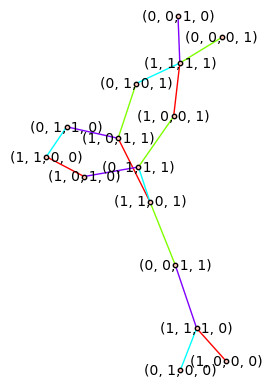

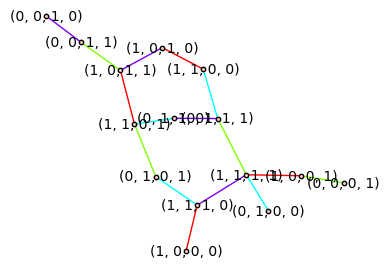

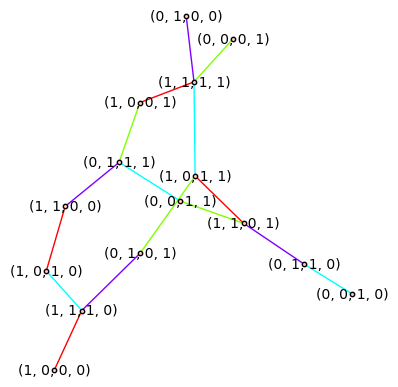

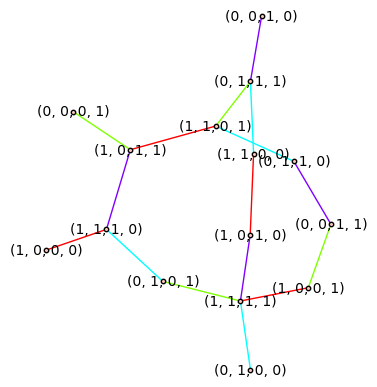

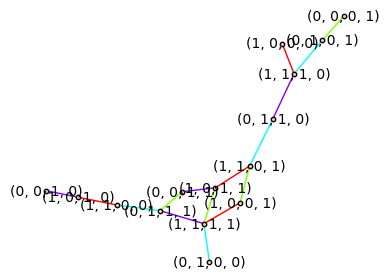

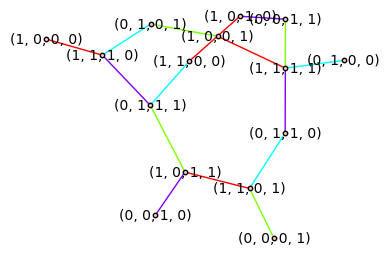

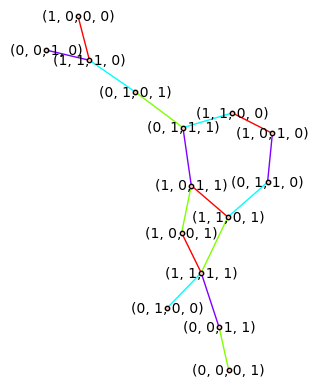

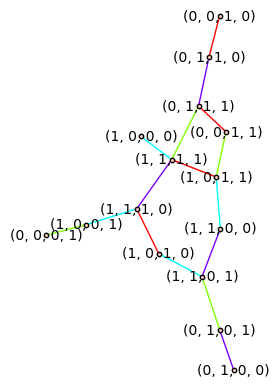

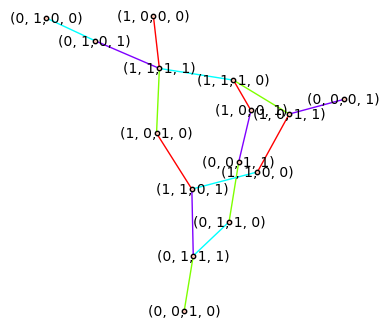

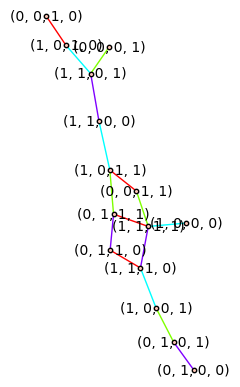

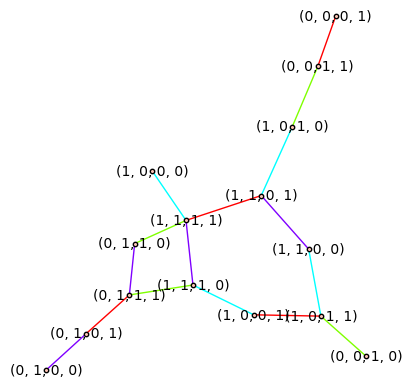

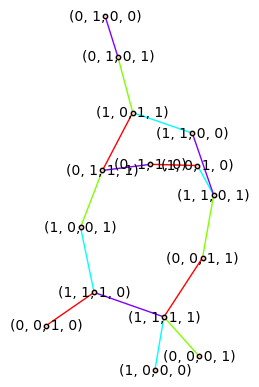

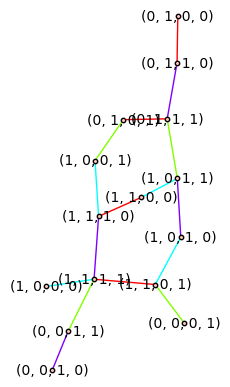

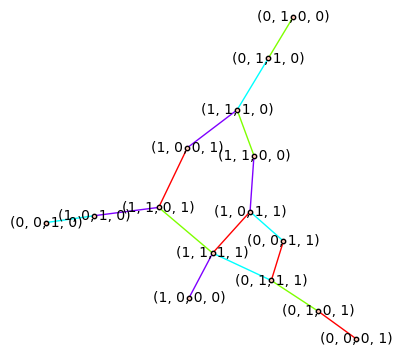

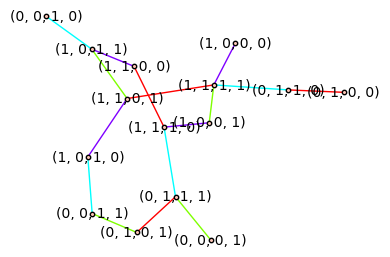

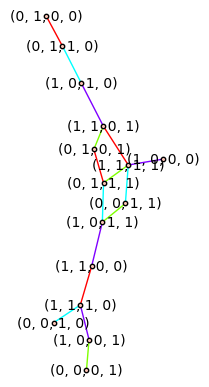

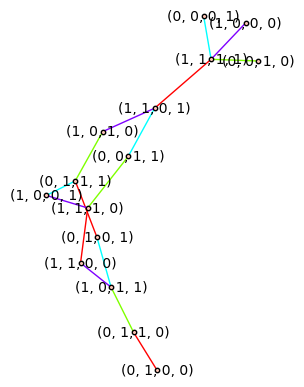

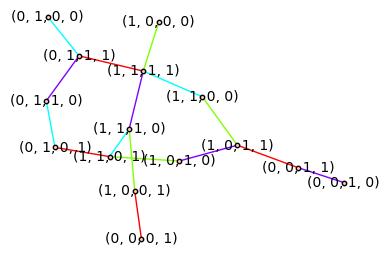

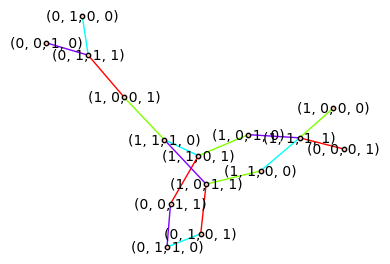

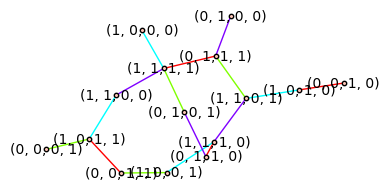

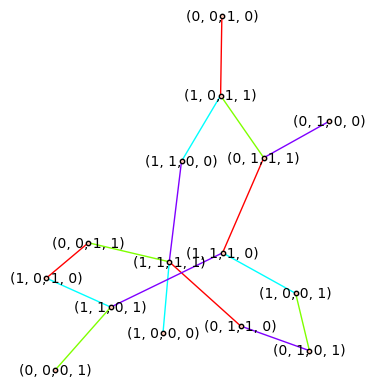

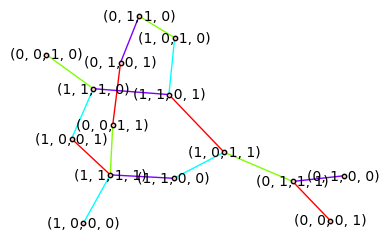

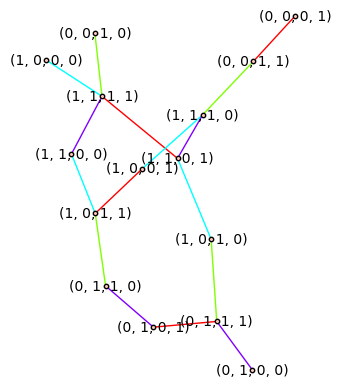

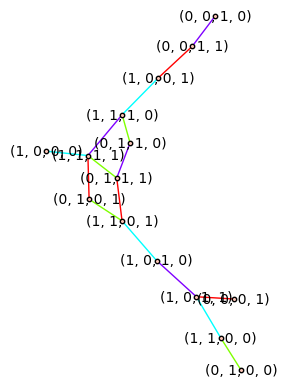

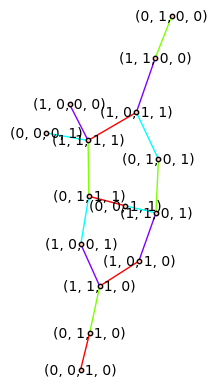

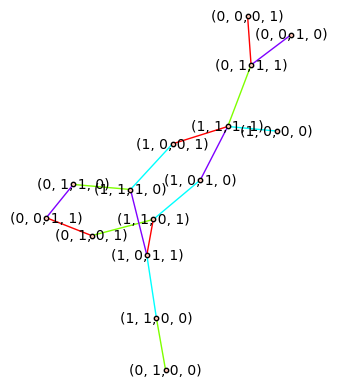

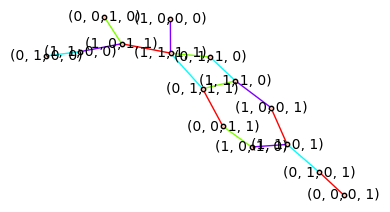

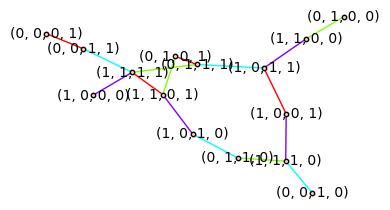

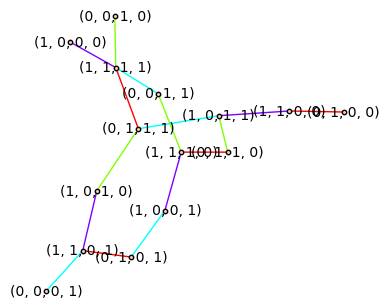

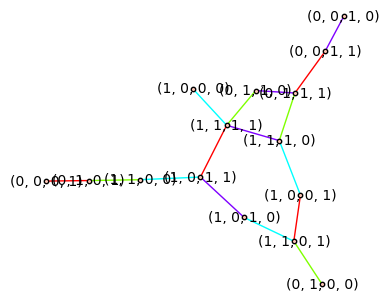

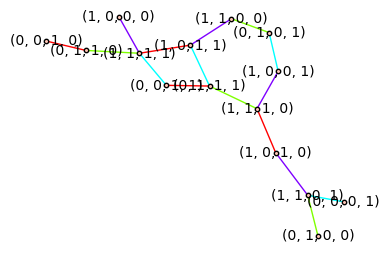

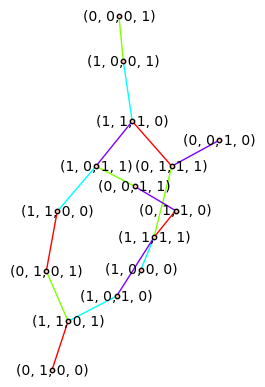

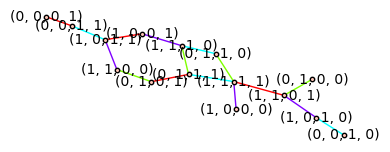

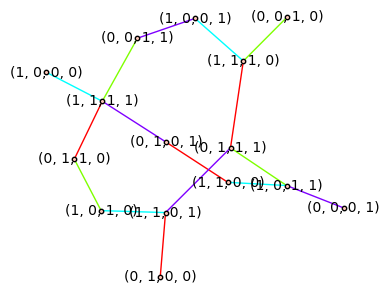

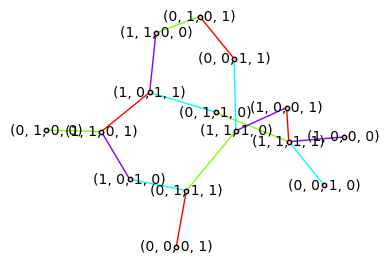

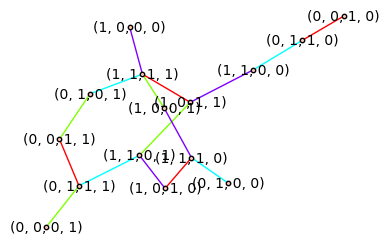

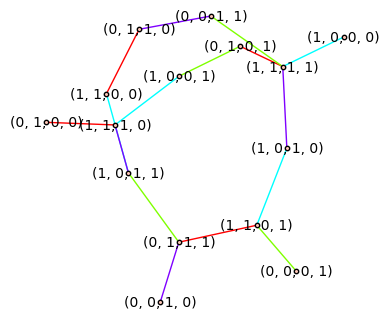

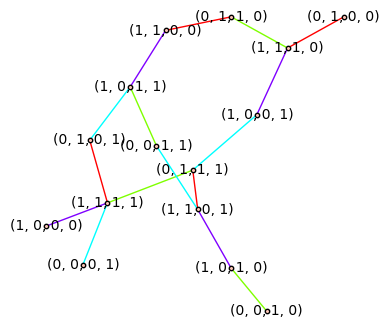

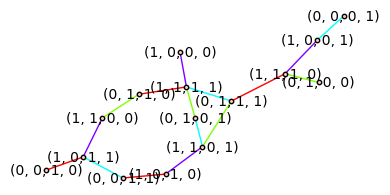

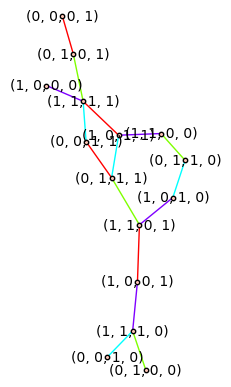

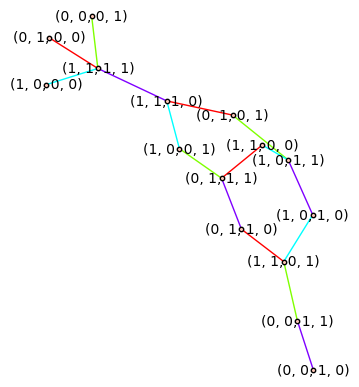

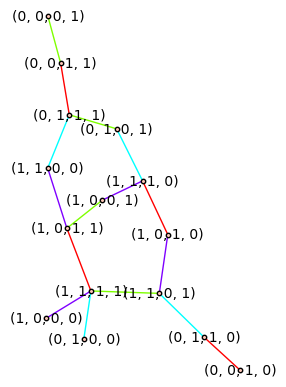

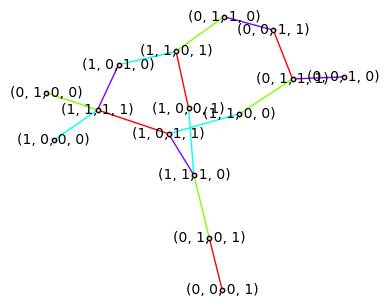

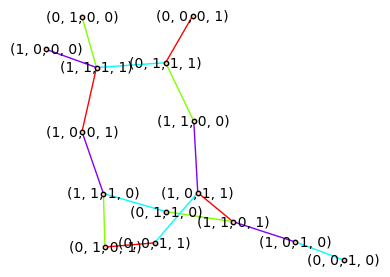

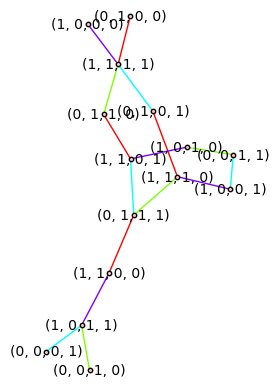

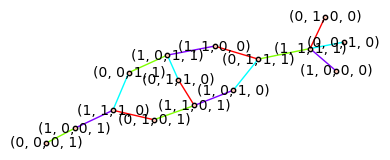

skip


In [195]:
#Play around with the vertex labeling. It can get pretty crazy as n grows.
for r_s in fact_fixed_conj:
    Mlist = get_adj_matrix(r_s)
    #[M1,M2,M3]=get_adj_matrix(rrr[0])
    Dlist= [DiGraph(adj_m) for adj_m in Mlist]
    alledge=[]
    for i in range(n):
        for u,v,l in Dlist[i].edges():
            Dlist[i].set_edge_label(u,v,str(i))
        alledge = alledge+Dlist[i].edges()
    D=DiGraph()
    D.add_edges(alledge)
    D.relabel(vertex)
    G=D.to_undirected()
    #G.delete_vertices([vertex[0],vertex[1],vertex[4]])
    G.graphplot(color_by_label=True,vertex_size=10,layout='spring',vertex_labels=True).show()
    #G.save(str(i).png)


In [19]:
#fact = factorization, c = singer
#returns the cyclic orbit
def cyclic_orbit(fact, c):
    cyclic=[]
    while 1:
        f = fact[-1]
        fact.remove(f)
        fact.insert(0,c*f*c^(-1))
        if fact not in cyclic:
            cyclic.append(copy(fact))
        else:
            break
    return cyclic

In [20]:
for f in fact_g:
    cyc = cyclic_orbit(f,prod(f))
    if len(cyc) == 13:
        thef = f

In [87]:
for new in newlist:
    for rrr in new:    
        symm=[]
        Mlist =get_adj_matrix(rrr)
        for m in Mlist:
            D= DiGraph(m)
            G=D.to_directed()
            #G.show()
            cycle = G.all_simple_cycles()
            #print(edge)
            tup=[]
            for c in cycle:
                newc=[x+1 for x in c[1:]]
                tup.append(tuple(newc))
            #print(tup)
            refl = GG(tup)
            symm.append(refl)
        print(symm,prod(symm))
    print('skip')

[(1,11,8)(3,12,10)(4,13,9), (2,3,4)(6,12,9)(7,10,13), (5,6,7)(8,9,10)(11,12,13)] (1,12,11,9,2,3,10,4,5,6,13,7,8)
[(1,8,11)(3,10,12)(4,9,13), (2,3,4)(6,12,9)(7,10,13), (5,7,6)(8,10,9)(11,13,12)] (1,10,8,13,2,3,12,4,5,7,9,6,11)
[(1,8,11)(3,10,12)(4,9,13), (2,4,3)(6,9,12)(7,13,10), (5,6,7)(8,9,10)(11,12,13)] (1,9,8,12,2,4,13,3,5,6,10,7,11)
[(1,11,8)(3,12,10)(4,13,9), (2,4,3)(6,9,12)(7,13,10), (5,7,6)(8,10,9)(11,13,12)] (1,13,11,10,2,4,9,3,5,7,12,6,8)
skip
[(1,11,8)(3,12,10)(4,13,9), (2,10,9)(3,13,6)(4,7,12), (5,12,10)(6,13,8)(7,11,9)] (1,9,11,6,3,4,13,2,5,12,7,10,8)
[(1,8,11)(3,10,12)(4,9,13), (2,12,13)(3,9,7)(4,6,10), (5,10,12)(6,8,13)(7,9,11)] (1,13,8,7,3,4,9,2,5,10,6,12,11)
[(1,8,11)(3,10,12)(4,9,13), (2,13,12)(3,7,9)(4,10,6), (5,9,13)(6,10,11)(7,8,12)] (1,12,8,6,4,3,10,2,5,9,7,13,11)
[(1,11,8)(3,12,10)(4,13,9), (2,9,10)(3,6,13)(4,12,7), (5,13,9)(6,11,10)(7,12,8)] (1,10,11,7,4,3,12,2,5,13,6,9,8)
skip
[(1,8,11)(3,10,12)(4,9,13), (2,10,9)(3,13,6)(4,7,12), (5,13,9)(6,11,10)(7,12,8)] (1,7,

In [23]:
alledge

[(0, 6, '0'),
 (2, 5, '0'),
 (5, 2, '0'),
 (6, 0, '0'),
 (1, 6, '1'),
 (2, 4, '1'),
 (4, 2, '1'),
 (6, 1, '1'),
 (3, 4, '2'),
 (4, 3, '2'),
 (5, 6, '2'),
 (6, 5, '2')]

In [273]:
for rrr in fact_g:
    [M1,M2,M3]=get_adj_matrix(rrr)
    Dlist=DiGraph(M1),DiGraph(M2),DiGraph(M3)
    alledge=[]
    for i in range(n):
        for u,v,l in Dlist[i].edges():
            Dlist[i].set_edge_label(u,v,str(i))
        alledge = alledge+Dlist[i].edges()
    D=DiGraph()
    D.add_edges(alledge)
    D.relabel(vertex)
    G=D.to_undirected()
    #G.delete_vertices([vertex[0],vertex[1],vertex[4]])
    G.graphplot(color_by_label=True,vertex_size=0,layout='spring').show()
print('skip')

skip


In [144]:
for rrr in fact_g:    
    symm=[]
    Mlist =get_adj_matrix(rrr)
    for m in Mlist:
        D= DiGraph(m)
        G=D.to_directed()
        #G.show()
        cycle = G.all_simple_cycles()
        #print(edge)
        tup=[]
        for c in cycle:
            newc=[x+1 for x in c[1:]]
            tup.append(tuple(newc))
        #print(tup)
        refl = GG(tup)
        symm.append(refl)
    print(symm,prod(symm))

[(1,6)(3,7), (2,3)(5,7), (4,5)(6,7)] (1,7,2,3,4,5,6)
[(1,6)(3,7), (2,7)(3,5), (4,7)(5,6)] (1,5,3,2,4,7,6)
[(1,3)(6,7), (2,5)(3,7), (4,7)(5,6)] (1,4,7,5,2,6,3)
[(1,3)(6,7), (2,7)(3,5), (4,6)(5,7)] (1,7,4,6,2,5,3)
[(1,7)(3,6), (2,5)(3,7), (4,6)(5,7)] (1,3,4,6,5,2,7)
[(1,7)(3,6), (2,3)(5,7), (4,7)(5,6)] (1,6,2,3,5,4,7)
[(1,7)(3,6), (2,7)(3,5), (4,5)(6,7)] (1,2,6,4,5,3,7)


In [279]:
str(5)

'5'

In [56]:

for new in newlist:
    for rrr in new:    
        symm=[]
        Mlist =get_adj_matrix(rrr)
        for m in Mlist:
            D= DiGraph(m)
            G=D.to_directed()
            #G.show()
            cycle = G.all_simple_cycles()
            #print(edge)
            tup=[]
            for c in cycle:
                newc=[x+1 for x in c[1:]]
                tup.append(tuple(newc))
            #print(tup)
            refl = GG(tup)
            symm.append(refl)
        print(symm,prod(symm))
    print('skip')

[(1,11,8)(3,12,10)(4,13,9), (2,3,4)(6,12,9)(7,10,13), (5,6,7)(8,9,10)(11,12,13)] (1,12,11,9,2,3,10,4,5,6,13,7,8)
[(1,8,11)(3,10,12)(4,9,13), (2,3,4)(6,12,9)(7,10,13), (5,7,6)(8,10,9)(11,13,12)] (1,10,8,13,2,3,12,4,5,7,9,6,11)
[(1,8,11)(3,10,12)(4,9,13), (2,4,3)(6,9,12)(7,13,10), (5,6,7)(8,9,10)(11,12,13)] (1,9,8,12,2,4,13,3,5,6,10,7,11)
[(1,11,8)(3,12,10)(4,13,9), (2,4,3)(6,9,12)(7,13,10), (5,7,6)(8,10,9)(11,13,12)] (1,13,11,10,2,4,9,3,5,7,12,6,8)
skip
[(1,11,8)(3,12,10)(4,13,9), (2,10,9)(3,13,6)(4,7,12), (5,12,10)(6,13,8)(7,11,9)] (1,9,11,6,3,4,13,2,5,12,7,10,8)
[(1,8,11)(3,10,12)(4,9,13), (2,12,13)(3,9,7)(4,6,10), (5,10,12)(6,8,13)(7,9,11)] (1,13,8,7,3,4,9,2,5,10,6,12,11)
[(1,8,11)(3,10,12)(4,9,13), (2,13,12)(3,7,9)(4,10,6), (5,9,13)(6,10,11)(7,8,12)] (1,12,8,6,4,3,10,2,5,9,7,13,11)
[(1,11,8)(3,12,10)(4,13,9), (2,9,10)(3,6,13)(4,12,7), (5,13,9)(6,11,10)(7,12,8)] (1,10,11,7,4,3,12,2,5,13,6,9,8)
skip
[(1,8,11)(3,10,12)(4,9,13), (2,10,9)(3,13,6)(4,7,12), (5,13,9)(6,11,10)(7,12,8)] (1,7,

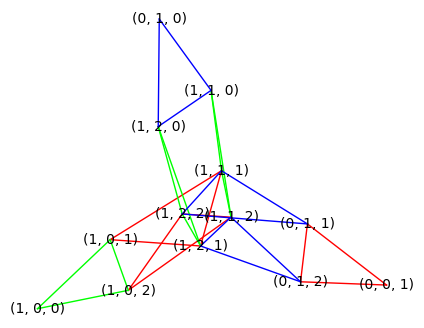

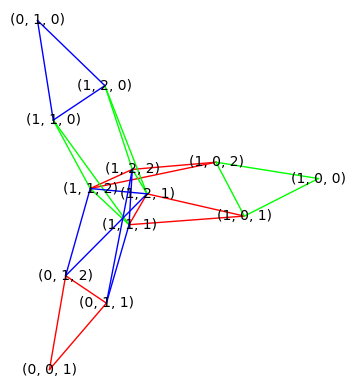

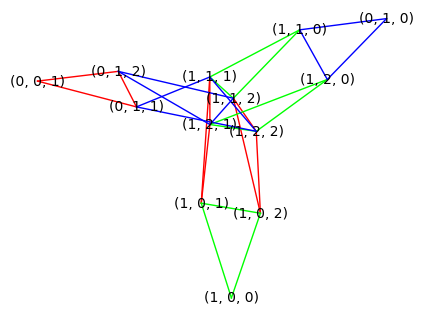

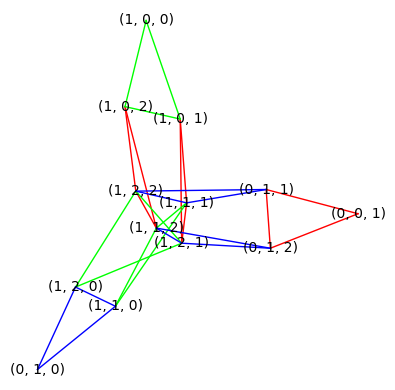

skip


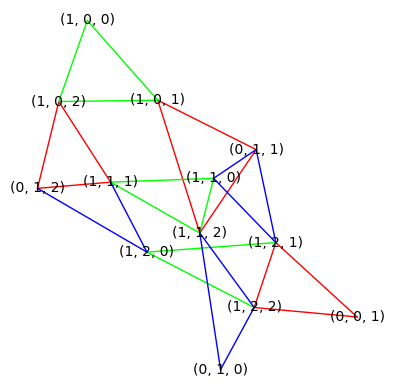

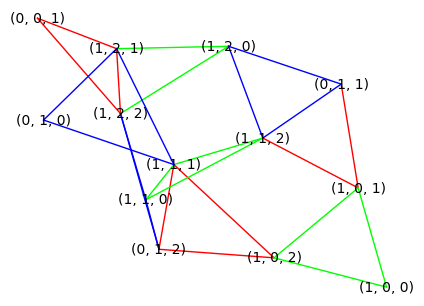

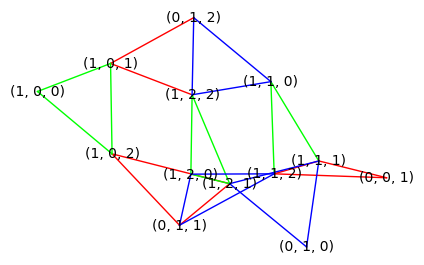

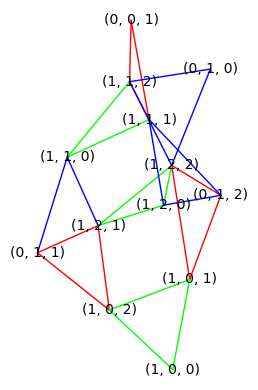

skip


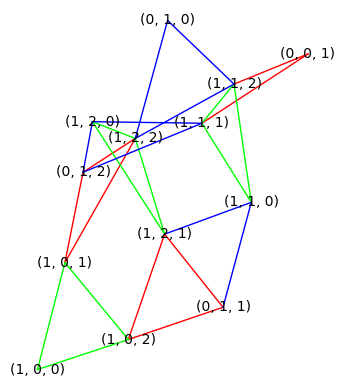

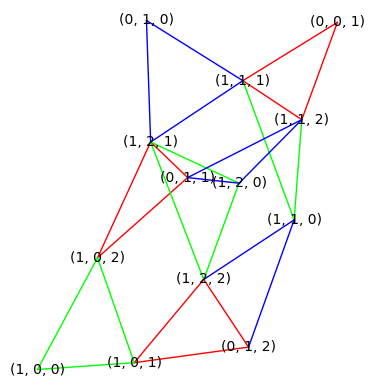

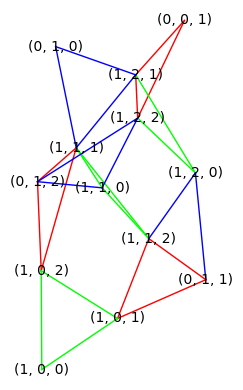

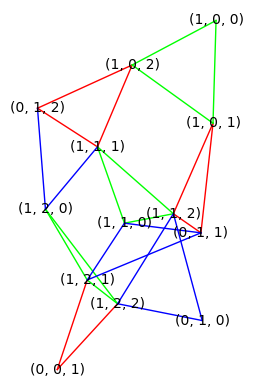

skip


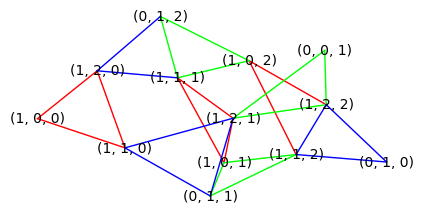

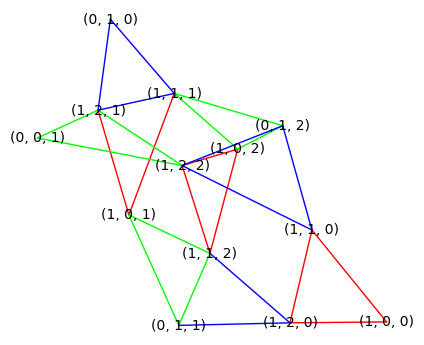

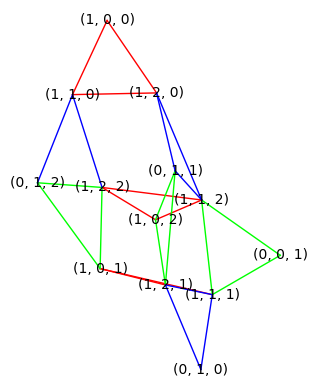

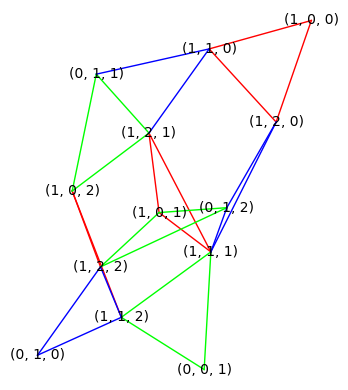

skip


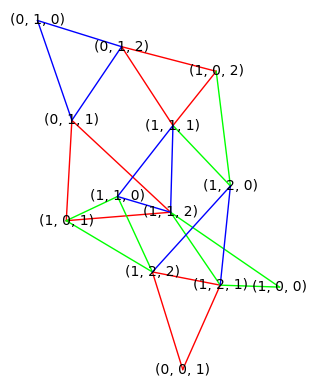

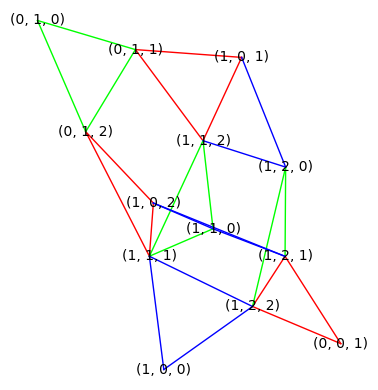

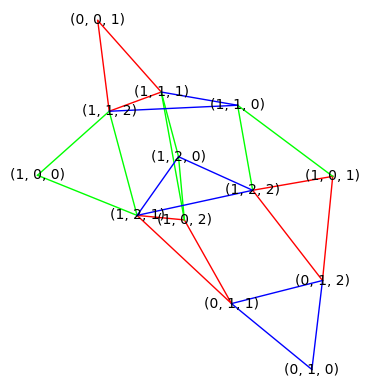

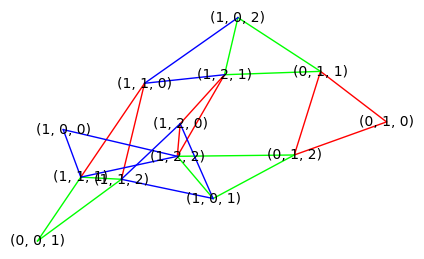

skip


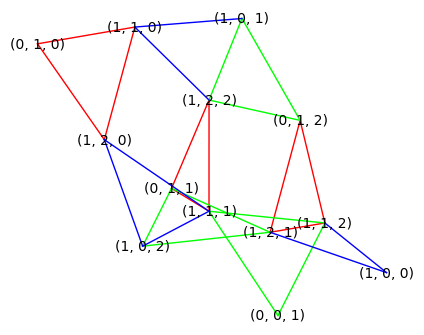

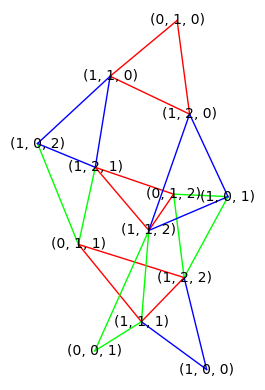

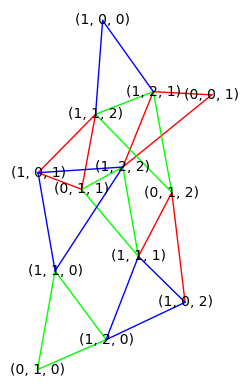

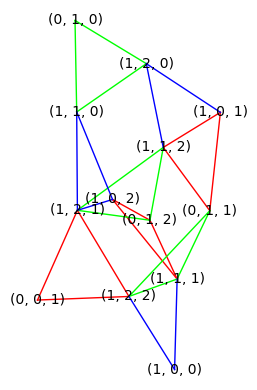

skip


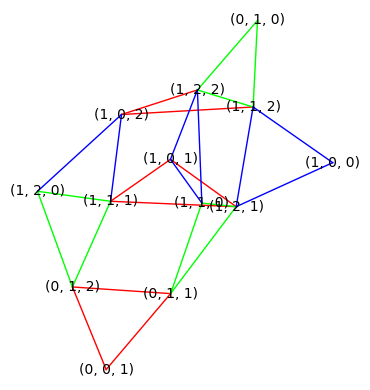

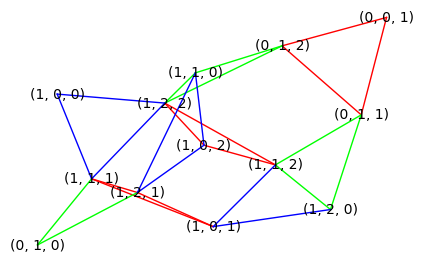

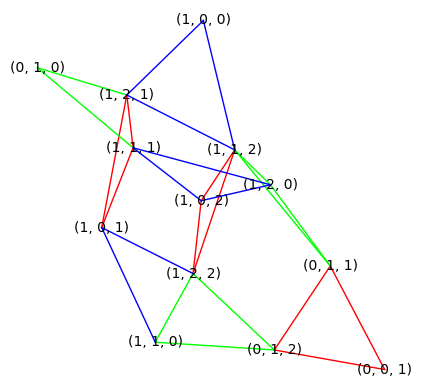

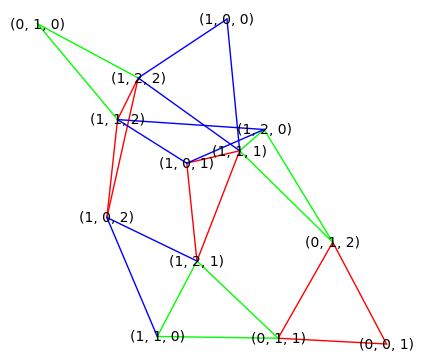

skip


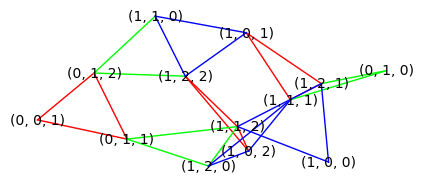

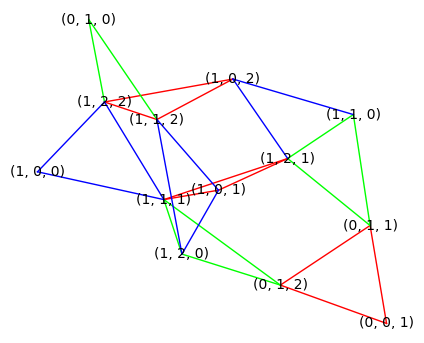

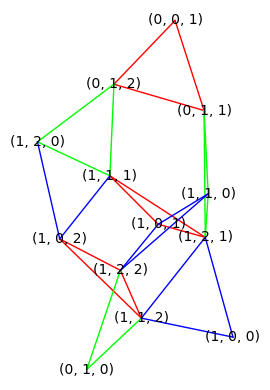

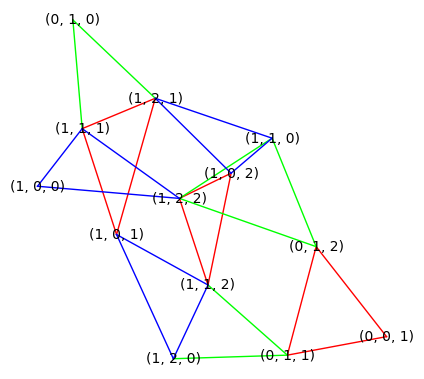

skip


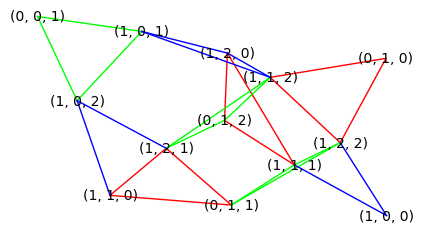

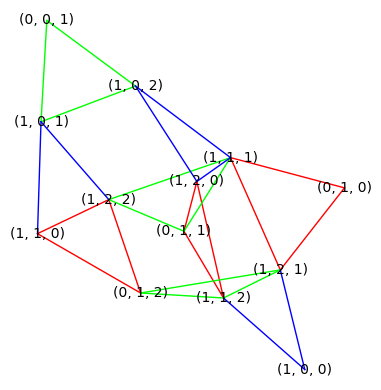

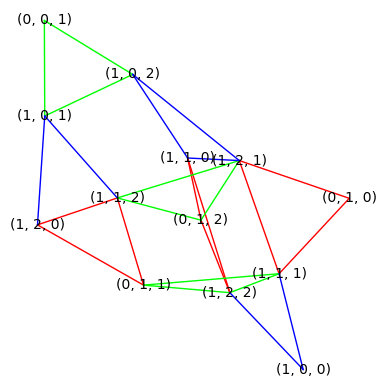

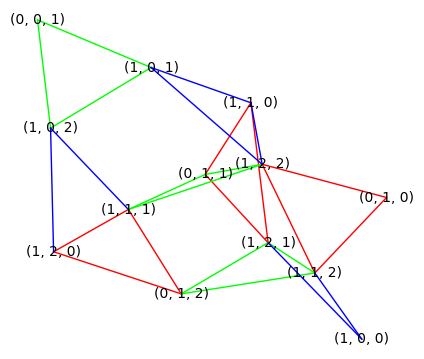

skip


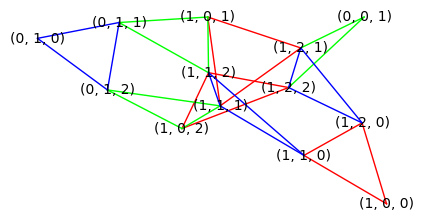

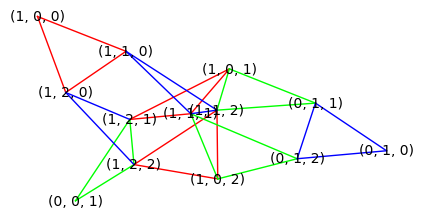

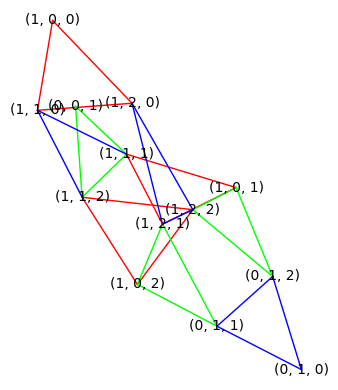

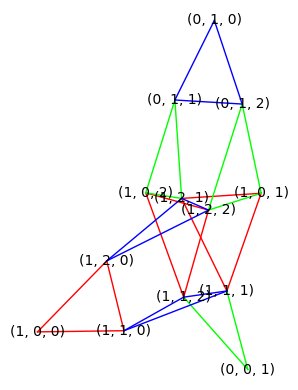

skip


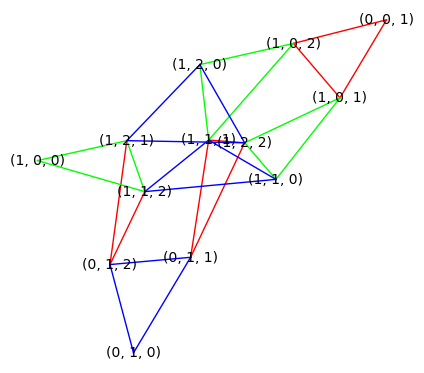

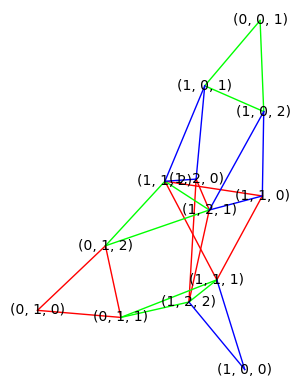

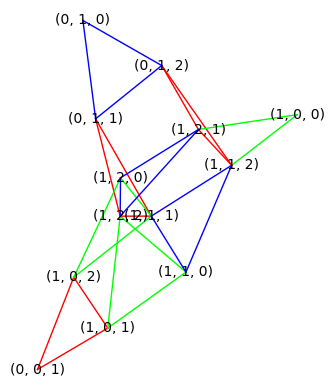

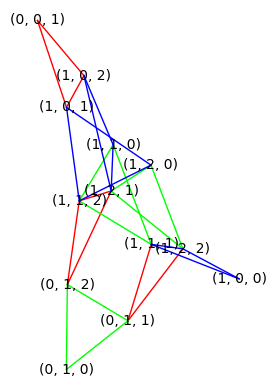

skip


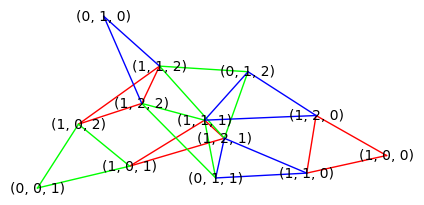

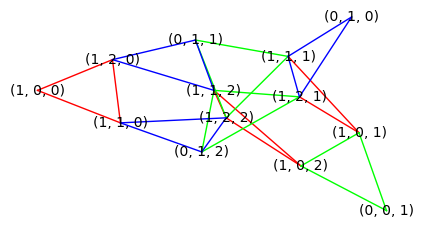

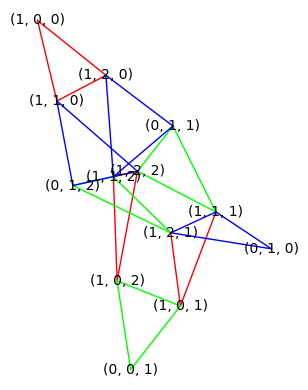

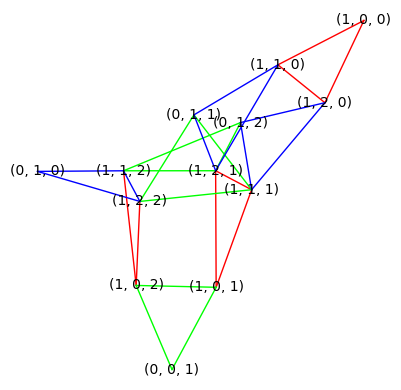

skip


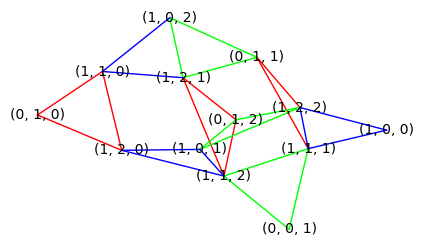

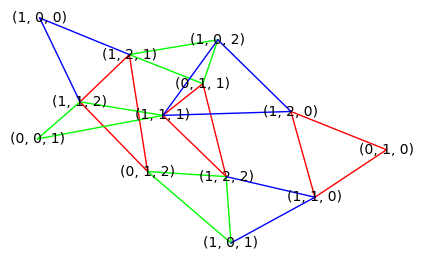

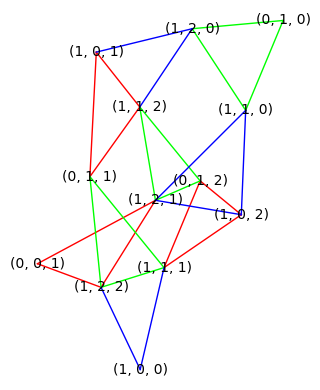

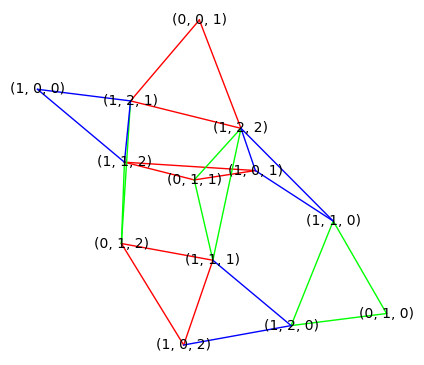

skip


In [23]:
for new in newlist: 
    for rrr in new:
        [M1,M2,M3]=get_adj_matrix(rrr)
        Dlist=DiGraph(M1),DiGraph(M2),DiGraph(M3)
        alledge=[]
        for i in range(n):
            for u,v,l in Dlist[i].edges():
                Dlist[i].set_edge_label(u,v,str(i))
            alledge = alledge+Dlist[i].edges()
        D=DiGraph()
        D.add_edges(alledge)
        D.relabel(vertex)
        G=D.to_undirected()
        #G.delete_vertices([vertex[0],vertex[1],vertex[4]])
        G.graphplot(color_by_label=True,vertex_size=0,layout='spring').show()
    print('skip')

In [55]:
def labeled_tree2fact(ep):
    return [(e[0]+1,e[1]+1) for e in ep]

GG=SymmetricGroup(nq)

In [52]:
def is_reflection(g):
    n = G.degree()
    M = g.matrix() - (G[0]^0).matrix()
    KM = M.kernel()
    return KM.dimension() == n-1

def is_transvection(g):
    return is_reflection(g) and M(g).determinant() == 1


def get_transvections(): #find all transvection in a list
    R = []
    for g in G:
        if is_transvection(g):
            R.append(g)
    return R

def get_refls(): #find all reflections in a list
    R = []
    for g in G:
        if is_reflection(g):
            R.append(g)
    return R
def get_fact(R,c):#given a list of reflections and a singer cycle returns the list of factorization in reflections
    F = []
    for i in product(range(len(R)),repeat = G.degree()):
        if mul([R[i[k]] for k in range(G.degree())]) == c:
            F.append([R[i[k]] for k in range(G.degree())])
    return F

In [59]:
R=get_refls()
fact1=get_fact(R,sing[0])

In [60]:
len(fact1)

49

In [132]:
#for new in fact_g:
    #print('space')
for rrr in fact1:  
    symm=[]
    Mlist =get_adj_matrix(rrr)
    for m in Mlist:
        D= DiGraph(m)
        G=D.to_undirected()
        edge = labeled_tree2fact(G.edges())
        refl = GG(edge)
        symm.append(refl)
    print(symm,prod(symm))

[(1,4)(2,7), (1,6)(3,4), (4,5)(6,7)] (1,3,5,4,7,2,6)
[(1,4)(2,7), (1,7)(3,5), (1,6)(3,4)] (1,3,5,4,7,2,6)
[(1,4)(2,7), (4,5)(6,7), (1,7)(3,5)] (1,3,5,4,7,2,6)
[(2,4)(3,5), (1,4)(2,7), (1,6)(3,4)] (1,3,5,4,7,2,6)
[(2,4)(3,5), (1,6)(3,4), (2,7)(3,6)] (1,3,5,4,7,2,6)
[(2,4)(3,5), (2,7)(3,6), (1,3)(4,6)] (1,3,5,4,7,2,6)
[(2,4)(3,5), (1,3)(4,6), (1,4)(2,7)] (1,3,5,4,7,2,6)
[(1,6)(3,4), (2,6)(3,7), (2,3)(4,5)] (1,3,5,4,7,2,6)
[(1,6)(3,4), (2,7)(3,6), (4,5)(6,7)] (1,3,5,4,7,2,6)
[(1,6)(3,4), (4,5)(6,7), (2,6)(3,7)] (1,3,5,4,7,2,6)
[(1,6)(3,4), (2,3)(4,5), (2,7)(3,6)] (1,3,5,4,7,2,6)
[(1,3)(5,7), (1,6)(2,5), (4,7)(5,6)] (1,3,5,4,7,2,6)
[(1,3)(5,7), (1,5)(2,6), (1,2)(4,7)] (1,3,5,4,7,2,6)
[(1,3)(5,7), (1,2)(4,7), (1,6)(2,5)] (1,3,5,4,7,2,6)
[(1,3)(5,7), (4,7)(5,6), (1,5)(2,6)] (1,3,5,4,7,2,6)
[(1,7)(3,5), (1,6)(3,4), (2,6)(3,7)] (1,3,5,4,7,2,6)
[(1,7)(3,5), (2,6)(3,7), (1,2)(4,7)] (1,3,5,4,7,2,6)
[(1,7)(3,5), (1,2)(4,7), (1,6)(3,4)] (1,3,5,4,7,2,6)
[(1,6)(2,5), (2,4)(3,5), (2,7)(3,6)] (1,3,5,4,

In [83]:
vertex

{0: '(1, 0, 0)',
 1: '(0, 1, 0)',
 2: '(1, 2, 0)',
 3: '(1, 1, 0)',
 4: '(0, 0, 1)',
 5: '(0, 1, 2)',
 6: '(0, 1, 1)',
 7: '(1, 0, 2)',
 8: '(1, 1, 2)',
 9: '(1, 2, 2)',
 10: '(1, 0, 1)',
 11: '(1, 2, 1)',
 12: '(1, 1, 1)'}

In [51]:
#for new in fact_g:
    #print('space')
for rrr in fact_g:  
    symm=[]
    Mlist =get_adj_matrix(rrr)
    for m in Mlist:
        D= DiGraph(m)
        G=D.to_undirected()
        edge = labeled_tree2fact(G.edges())
        refl = GG(edge[1:4])
        symm.append(refl)
    print(symm,prod(symm))

[(3,9)(4,10)(12,13), (6,10)(7,12)(9,13), (6,8)(7,10)(11,12)] (3,13,10,4,8,6,7,11,12,9)
[(3,9)(4,10)(12,13), (3,6)(4,9)(7,10), (8,12)(9,11)(10,13)] (3,4,7,13,8,12,10,11,9,6)
[(3,9)(4,10)(12,13), (3,7)(4,13)(6,12), (6,11)(7,13)(8,9)] (3,8,9,13,11,6,12,4,10,7)
[(3,9)(4,10)(12,13), (6,13)(7,9)(10,12), (6,9)(7,8)(11,13)] (3,8,7,6,11,13,10,4,12,9)
[(3,9)(4,10)(12,13), (3,12)(4,6)(7,13), (6,12)(7,11)(8,10)] (3,9,6,4,8,10,12,11,7,13)
[(3,9)(4,10)(12,13), (3,10)(4,7)(6,9), (8,13)(9,12)(10,11)] (3,6,12,8,13,9,11,10,7,4)
[(3,13)(4,12)(9,10), (6,10)(7,12)(9,13), (6,12)(7,11)(8,10)] (3,9,12,4,11,7,6,8,10,13)
[(3,13)(4,12)(9,10), (3,6)(4,9)(7,10), (6,9)(7,8)(11,13)] (3,11,13,9,8,7,10,4,12,6)
[(3,13)(4,12)(9,10), (3,7)(4,13)(6,12), (8,13)(9,12)(10,11)] (3,4,6,9,11,10,12,8,13,7)
[(3,13)(4,12)(9,10), (6,13)(7,9)(10,12), (6,11)(7,13)(8,9)] (3,11,6,7,8,9,12,4,10,13)
[(3,13)(4,12)(9,10), (3,12)(4,6)(7,13), (8,12)(9,11)(10,13)] (3,7,10,11,9,13,8,12,6,4)
[(3,13)(4,12)(9,10), (3,10)(4,7)(6,9), (6,8)(7,10)(11

In [145]:
fact_g[1],prod(fact_g[1])

(
[[1 0 1]                 
[0 1 0]                  
[0 0 1], [1 0 0]         
[1 1 1]                  
[0 0 1], [1 0 0]  [1 1 1]
[0 1 0]           [1 0 1]
[0 1 1]]        , [0 1 1]
)

In [104]:
#for new in fact_g:
    #print('space')
for rrr in fact_g:  
    symm=[]
    Mlist =get_adj_matrix(rrr)
    for m in Mlist:
        D= DiGraph(m)
        G=D.to_undirected()
        edge = labeled_tree2fact(G.edges())
        refl = GG(edge)
        symm.append(refl)
    print(symm,prod(symm))

[(4,5)(6,7), (2,6)(3,7), (1,7)(3,5)] (1,7,2,6,5,4,3)
[(4,5)(6,7), (2,7)(3,6), (1,3)(5,7)] (1,3,6,2,5,4,7)
[(4,6)(5,7), (2,3)(6,7), (1,5)(3,7)] (1,5,6,4,3,2,7)
[(4,6)(5,7), (2,7)(3,6), (1,7)(3,5)] (1,7,3,6,4,5,2)
[(4,7)(5,6), (2,3)(6,7), (1,7)(3,5)] (1,7,4,6,3,2,5)
[(4,7)(5,6), (2,6)(3,7), (1,3)(5,7)] (1,3,5,2,6,7,4)
[(4,7)(5,6), (2,7)(3,6), (1,5)(3,7)] (1,5,7,4,2,3,6)
